In [1]:
# %% [markdown]
# # Extract GRACE Mascon TWS Anomalies -> Country CSV
# Inputs:
#  - GRACE NetCDF (example name): GRCTellus.JPL.200204_202507.GLO.RL06.3M.MSCNv04CRI.nc
#  - Country shapefile (Natural Earth or local): e.g., ne_50m_admin_0_countries.shp
# Outputs:
#  - grace_country_monthly_anomalies.csv  (columns: iso_a3, country, date, twa_mean_cm, twa_median_cm, n_valid_cells)
#
# Notes:
#  - Requires: xarray, rioxarray, rasterio, rasterstats, geopandas, pandas, numpy, tqdm
#  - Strategy: for each monthly slice, write an in-memory GeoTIFF (rioxarray) then run rasterstats zonal_stats for polygons.


In [2]:
# %% [markdown]
# ## 0) Install dependencies (run if needed)
# In your shell:
# pip install xarray rioxarray rasterio rasterstats geopandas pandas numpy tqdm netcdf4


In [3]:
import os
!pip install xarray rioxarray rasterio rasterstats geopandas pandas numpy tqdm netcdf4
from pathlib import Path
import xarray as xr
import rioxarray  # registers rasterio with xarray
import geopandas as gpd
import pandas as pd
import numpy as np
from rasterstats import zonal_stats
from tqdm import tqdm
from datetime import datetime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.7 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Paths - change these to match your local files
GRACE_NC = "/content/drive/MyDrive/EDA-data/grace_data.nc"  # <-- your GRACE file
COUNTRY_SHP = "/content/drive/MyDrive/EDA-data/shapefiles/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"  # e.g., Natural Earth shapefile (download if you don't have)
OUT_CSV = "grace_country_monthly_anomalies.csv"
TMP_DIR = "tmp_grace_tifs"
os.makedirs(TMP_DIR, exist_ok=True)

In [6]:
# Quick checks
if not Path(GRACE_NC).exists():
    raise FileNotFoundError(f"GRACE file not found: {GRACE_NC}")
if not Path(COUNTRY_SHP).exists():
    raise FileNotFoundError(f"Country shapefile not found: {COUNTRY_SHP}")

In [7]:
# %% [code]
# 1) Open GRACE dataset and inspect variables
ds = xr.open_dataset(GRACE_NC)
print(ds)
# Typical variable name: 'lwe_thickness' or similar
# Print variables to confirm:
print("Variables:", list(ds.data_vars))


<xarray.Dataset> Size: 2GB
Dimensions:        (time: 247, lat: 360, lon: 720, bounds: 2)
Coordinates:
  * time           (time) datetime64[ns] 2kB 2002-04-17T12:00:00 ... 2025-07-...
  * lat            (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * lon            (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 512MB ...
    uncertainty    (time, lat, lon) float64 512MB ...
    lat_bounds     (lat, bounds) float64 6kB ...
    lon_bounds     (lon, bounds) float64 12kB ...
    time_bounds    (time, bounds) datetime64[ns] 4kB ...
    land_mask      (lat, lon) float64 2MB ...
    scale_factor   (lat, lon) float64 2MB ...
    mascon_ID      (lat, lon) float64 2MB ...
    GAD            (time, lat, lon) float64 512MB ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0

In [8]:
# %% [code]
# pick variable name (inspect ds to confirm)
# Common variable name -> 'lwe_thickness' (liquid water equivalent thickness anomaly, cm)
if 'lwe_thickness' in ds:
    varname = 'lwe_thickness'
elif 'lwe' in ds:
    varname = [v for v in ds.data_vars if 'lwe' in v][0]
else:
    # fallback to the first 3D variable
    three_d_vars = [v for v in ds.data_vars if ds[v].ndim == 3]
    if not three_d_vars:
        raise RuntimeError("No 3D variable found in the GRACE file.")
    varname = three_d_vars[0]

print("Using variable:", varname)
tws = ds[varname]  # dims typically: time, lat, lon


Using variable: lwe_thickness


In [9]:
# %% [markdown]
# ## 2) Load countries shapefile and prepare


In [10]:
# %% [code]
gdf_countries = gpd.read_file(COUNTRY_SHP)
# Ensure country polygons are valid and have iso_a3 or ISO_A3 column
print("Country columns:", gdf_countries.columns.tolist())
# Try to get ISO3 code column name
iso_cols = [c for c in gdf_countries.columns if c.lower() in ('iso_a3', 'iso3', 'adm0_a3', 'iso_a3_eh')]
iso_col = iso_cols[0] if iso_cols else None
if iso_col is None:
    raise RuntimeError("Cannot find ISO3 column in countries shapefile. Please provide shapefile with iso_a3 or iso3.")
print("Using ISO column:", iso_col)

# Reproject country polygons to match GRACE CRS (GRACE usually lat/lon WGS84)
gdf_countries = gdf_countries.to_crs("EPSG:4326")
gdf_countries['geometry'] = gdf_countries['geometry'].buffer(0)  # fix small geometry issues


Country columns: ['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3', 'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT', 'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG', 'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN', 'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT', 'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13', 'POP_EST', 'POP_RANK', 'POP_YEAR', 'GDP_MD', 'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'FIPS_10', 'ISO_A2', 'ISO_A2_EH', 'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'ISO_N3_EH', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID', 'WOE_ID_EH', 'WOE_NOTE', 'ADM0_ISO', 'ADM0_DIFF', 'ADM0_TLC', 'ADM0_A3_US', 'ADM0_A3_FR', 'ADM0_A3_RU', 'ADM0_A3_ES', 'ADM0_A3_CN', 'ADM0_A3_TW', 'ADM0_A3_IN', 'ADM0_A3_NP', 'ADM0_A3_PK', 'ADM0_A3_DE', 'ADM0_A3_GB', 'ADM0_A3_BR', 'ADM0_A3_IL', 'ADM0_A3_PS', 'ADM0_A3_SA', 'ADM0_A3_EG', 'ADM0_A3_MA', 'ADM0_A3_PT', 'ADM0_A3_AR', 'ADM0_A3_JP', 'ADM0_A3_KO', 'ADM0_A3_VN', 

In [11]:
# %% [markdown]
# ## 3) Loop over each time slice, rasterize time slice to GeoTIFF, compute zonal stats
# This step can be slow for many months; use tqdm to track progress. We compute mean and median per country.


In [12]:
print(tws['lat'].values[:5], '...', tws['lat'].values[-5:])
print(tws['lon'].values[:5], '...', tws['lon'].values[-5:])
print("Latitude ascending?", tws['lat'][0] < tws['lat'][-1])


[-89.75 -89.25 -88.75 -88.25 -87.75] ... [87.75 88.25 88.75 89.25 89.75]
[0.25 0.75 1.25 1.75 2.25] ... [357.75 358.25 358.75 359.25 359.75]
Latitude ascending? <xarray.DataArray 'lat' ()> Size: 1B
array(True)
Attributes:
    units:          degrees_north
    long_name:      latitude
    standard_name:  latitude
    axis:           Y
    valid_min:      -89.75
    valid_max:      89.75
    bounds:         lat_bounds


In [13]:
# --- Convert longitudes from 0–360° to -180–180° ---
tws = tws.assign_coords(lon=(((tws.lon + 180) % 360) - 180))
tws = tws.sortby(tws.lon)


In [14]:
# 1️⃣ Open dataset
ds = xr.open_dataset("/content/drive/MyDrive/EDA-data/grace_data.nc")
tws = ds['lwe_thickness']

# 2️⃣ Fix longitudes (shift 0–360 → -180–180)
tws = tws.assign_coords(lon=(((tws.lon + 180) % 360) - 180))
tws = tws.sortby(tws.lon)

# 3️⃣ Confirm orientation
print(tws['lat'][0].values, '→', tws['lat'][-1].values)  # should go from -90 → 90
print(tws['lon'][0].values, '→', tws['lon'][-1].values)  # should go from -180 → 180

# 4️⃣ Then proceed with your fixed loop (the version I gave last message)


-89.75 → 89.75
-179.75 → 179.75


In [15]:
tws = tws.assign_coords(lon=(((tws.lon + 180) % 360) - 180)).sortby('lon')


In [16]:
arr = tws.isel(time=0).squeeze() # Define arr by selecting the first time slice
print(arr['lat'].values[:3], '...', arr['lat'].values[-3:])
print(arr['lon'].values[:3], '...', arr['lon'].values[-3:])

[-89.75 -89.25 -88.75] ... [88.75 89.25 89.75]
[-179.75 -179.25 -178.75] ... [178.75 179.25 179.75]


In [17]:
from rasterio.transform import from_origin
import numpy as np

# Ensure you've already converted lon from 0..360 to -180..180 and sorted:
# tws = tws.assign_coords(lon=(((tws.lon + 180) % 360) - 180)).sortby('lon')

results = []
times = pd.to_datetime(tws['time'].values)

for t in tqdm(times, desc="Processing months"):
    try:
        # select slice and squeeze
        arr = tws.sel(time=np.datetime64(t)).squeeze()

        # Rename dims to x,y expected by rioxarray and ensure order (y,x)
        if 'lon' in arr.dims and 'lat' in arr.dims:
            arr = arr.rename({'lon': 'x', 'lat': 'y'})
        arr = arr.transpose('y', 'x')  # ensures 2D array order

        # Quick sanity checks
        if arr['x'].size == 0 or arr['y'].size == 0:
            raise ValueError("Zero-length x or y axis")

        # compute resolution from coordinate centers (assumes regular grid)
        x = arr['x'].values
        y = arr['y'].values
        xres = float(np.abs(x[1] - x[0]))
        yres = float(np.abs(y[1] - y[0]))

        # build rasterio affine transform:
        # west = left edge (min lon) - half cell
        # north = top edge (max lat) + half cell (from_origin expects north)
        west = float(x.min() - xres/2.0)
        north = float(y.max() + yres/2.0)
        transform = from_origin(west, north, xres, yres)

        # write CRS and transform
        arr.rio.write_crs("EPSG:4326", inplace=True)
        arr.rio.write_transform(transform, inplace=True)

        # write GeoTIFF
        tifpath = tmp_tif_for_time(t)
        arr.rio.to_raster(tifpath)

        # compute zonal stats
        zs = zonal_stats(
            gdf_countries.geometry,
            tifpath,
            stats=['mean', 'median', 'count'],
            nodata=None,
            all_touched=True,
            geojson_out=False
        )

        # append results
        for i, stats in enumerate(zs):
            results.append({
                'iso_a3': gdf_countries.iloc[i][iso_col],
                'country': gdf_countries.iloc[i].get('NAME_EN', gdf_countries.iloc[i].get('NAME', gdf_countries.iloc[i].get('ADMIN', ''))),
                'date': pd.to_datetime(str(t)).strftime('%Y-%m-01'),
                'tws_mean_cm': stats.get('mean', np.nan),
                'tws_median_cm': stats.get('median', np.nan),
                'n_valid_cells': int(stats.get('count', 0))
            })
    except Exception as e:
        print(f"⚠️ Skipping {t}: {e}")
        continue


Processing months:   2%|▏         | 6/247 [00:00<00:08, 27.96it/s]

⚠️ Skipping 2002-04-17 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2002-05-10 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2002-08-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2002-09-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2002-10-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2002-11-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2002-12-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2003-01-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2003-02-15 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2003-03-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2003-04-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2003-05-11 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2003-07-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2003-08-16 12:00:00: name 'tmp_tif_for_time' is not 

Processing months:  13%|█▎        | 31/247 [00:00<00:02, 87.13it/s]

⚠️ Skipping 2004-01-07 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2004-02-17 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2004-03-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2004-04-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2004-05-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2004-06-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2004-07-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2004-08-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2004-09-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2004-10-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2004-11-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2004-12-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2005-01-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2005-02-15 00:00:00: name 'tmp_tif_for_time' is not 

Processing months:  25%|██▍       | 61/247 [00:00<00:01, 120.25it/s]

⚠️ Skipping 2005-09-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2005-10-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2005-11-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2005-12-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2006-01-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2006-02-15 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2006-03-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2006-04-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2006-05-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2006-06-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2006-07-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2006-08-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2006-09-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2006-10-16 12:00:00: name 'tmp_tif_for_time' is not 

Processing months:  38%|███▊      | 93/247 [00:00<00:01, 139.65it/s]

⚠️ Skipping 2008-05-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2008-06-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2008-07-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2008-08-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2008-09-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2008-10-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2008-11-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2008-12-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2009-01-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2009-02-15 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2009-03-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2009-04-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2009-05-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2009-06-16 00:00:00: name 'tmp_tif_for_time' is not 

Processing months:  50%|████▉     | 123/247 [00:01<00:00, 137.38it/s]

⚠️ Skipping 2011-07-18 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2011-08-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2011-09-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2011-10-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2011-11-01 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2012-01-01 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2012-01-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2012-02-15 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2012-03-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2012-04-04 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2012-06-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2012-07-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2012-08-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2012-09-13 00:00:00: name 'tmp_tif_for_time' is not 

Processing months:  63%|██████▎   | 156/247 [00:01<00:00, 150.75it/s]

⚠️ Skipping 2014-05-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2014-06-13 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2014-08-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2014-09-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2014-10-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2014-11-17 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2015-01-22 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2015-02-15 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2015-03-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2015-04-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2015-04-27 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2015-07-15 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2015-08-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2015-09-14 12:00:00: name 'tmp_tif_for_time' is not 

Processing months:  79%|███████▊  | 194/247 [00:01<00:00, 169.63it/s]

⚠️ Skipping 2019-04-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2019-05-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2019-06-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2019-07-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2019-08-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2019-09-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2019-10-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2019-11-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2019-12-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2020-01-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2020-02-15 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2020-03-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2020-04-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2020-05-16 12:00:00: name 'tmp_tif_for_time' is not 

Processing months:  94%|█████████▍| 232/247 [00:01<00:00, 144.22it/s]

⚠️ Skipping 2022-09-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2022-10-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2022-11-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2022-12-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2023-01-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2023-02-15 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2023-03-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2023-04-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2023-05-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2023-06-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2023-07-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2023-08-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2023-09-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2023-10-16 12:00:00: name 'tmp_tif_for_time' is not 

Processing months: 100%|██████████| 247/247 [00:01<00:00, 126.06it/s]

⚠️ Skipping 2024-08-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2024-09-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2024-10-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2024-11-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2024-12-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2025-01-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2025-02-15 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2025-03-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2025-04-16 00:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2025-05-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2025-06-16 12:00:00: name 'tmp_tif_for_time' is not defined
⚠️ Skipping 2025-07-16 12:00:00: name 'tmp_tif_for_time' is not defined


In [18]:
# Vectorized, no-TIFF method to get country monthly GRACE means
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from affine import Affine
from tqdm import tqdm
from pathlib import Path

# ====== CONFIG ======
GRACE_NC = "/content/drive/MyDrive/EDA-data/grace_data.nc"  # your file
COUNTRY_SHP = "/content/drive/MyDrive/EDA-data/shapefiles/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"  # natural earth with ISO_A3
OUT_CSV = "grace_country_monthly_anomalies.csv"

# ====== LOAD ======
ds = xr.open_dataset(GRACE_NC)
# auto-detect variable (common name: 'lwe_thickness')
varname = 'lwe_thickness' if 'lwe_thickness' in ds else [v for v in ds.data_vars if ds[v].ndim==3][0]
tws = ds[varname]  # dims: time, lat, lon (lon may be 0..360)
print("Using variable:", varname)
print(tws.dims, {d: s for d,s in zip(tws.dims,[tws.sizes[d] for d in tws.dims])})

# ====== fix longitudes 0..360 -> -180..180 ======
if tws['lon'].max() > 180:
    tws = tws.assign_coords(lon=(((tws.lon + 180) % 360) - 180)).sortby('lon')

# ensure lat/lon dims names
if 'lat' not in tws.dims or 'lon' not in tws.dims:
    raise RuntimeError("Expected 'lat' and 'lon' dims in GRACE file.")

# get coordinates arrays
lons = tws['lon'].values
lats = tws['lat'].values
nx = lons.size
ny = lats.size

# compute resolution (assume regular grid)
xres = float(np.abs(lons[1] - lons[0]))
yres = float(np.abs(lats[1] - lats[0]))

# make transform. rasterio.from_origin expects: west, north, xres, yres
west = float(lons.min() - xres/2.0)
north = float(lats.max() + yres/2.0)
transform = Affine.translation(west, north) * Affine.scale(xres, -yres)
# or use rasterio.transform.from_origin(west, north, xres, yres)

print("Grid shape:", ny, nx, "transform:", transform)

# ====== load countries and prepare geometries ======
gdf = gpd.read_file(COUNTRY_SHP).to_crs("EPSG:4326")
# find ISO column
iso_cols = [c for c in gdf.columns if c.lower() in ('iso_a3','iso3','adm0_a3','iso_a3_eh')]
if not iso_cols:
    raise RuntimeError("Country shapefile missing ISO3 column.")
iso_col = iso_cols[0]
gdf = gdf[[iso_col, 'geometry']].dropna(subset=[iso_col]).reset_index(drop=True)

# create list of (geometry, value) for rasterize
# value will be integer index to map back to ISO
shapes = ((geom, int(i+1)) for i, geom in enumerate(gdf.geometry))
mask_shape = (ny, nx)

# ====== rasterize once ======
print("Rasterizing country polygons to grid masks (this may take a moment)...")
country_mask = rasterize(
    shapes,
    out_shape=mask_shape,
    transform=transform,
    fill=0,
    all_touched=True,
    dtype='int32'
)
# country_mask[y,x] contains 0 for None, or integer id (1..N) mapping to gdf.iloc[id-1]
print("Unique mask values (sample):", np.unique(country_mask)[:10])

# ====== prepare mapping arrays ======
ids = np.unique(country_mask)
ids = ids[ids != 0]  # remove background
print("Number of countries present on grid:", len(ids))

# create a 2D array of weights = 1 where valid data, else 0
# We'll use xarray to broadcast

# Align tws dims to (time, y, x) where y is lat ascending
# tws currently has dims (time, lat, lon). Ensure order
tws2 = tws.rename({'lat':'y', 'lon':'x'}).transpose('time','y','x')

# Convert country_mask to DataArray-like numpy and compute masked means
results = []
times = pd.to_datetime(tws2['time'].values)
tq = tqdm(times, desc="Computing country means")
for ti, t in enumerate(tq):
    arr = tws2.isel(time=ti).values  # 2D numpy (ny, nx)
    # mask invalid values
    arr = np.where(np.isfinite(arr), arr, np.nan)

    # iterate country ids and compute mean (vectorized per id using boolean indexing)
    for idv in ids:
        mask = (country_mask == idv)
        if not mask.any():
            continue
        vals = arr[mask]
        if np.all(np.isnan(vals)):
            mean_val = np.nan
            median_val = np.nan
            count = 0
        else:
            mean_val = float(np.nanmean(vals))
            median_val = float(np.nanmedian(vals))
            count = int(np.count_nonzero(~np.isnan(vals)))
        row = {
            'iso_a3': gdf.iloc[idv-1][iso_col],
            'date': pd.to_datetime(str(t)).strftime('%Y-%m-01'),
            'tws_mean_cm': mean_val,
            'tws_median_cm': median_val,
            'n_valid_cells': count
        }
        results.append(row)

# Save as DataFrame/CSV
df_out = pd.DataFrame(results)
df_out.to_csv(OUT_CSV, index=False)
print("Wrote:", OUT_CSV)


Using variable: lwe_thickness
('time', 'lat', 'lon') {'time': 247, 'lat': 360, 'lon': 720}
Grid shape: 360 720 transform: | 0.50, 0.00,-180.00|
| 0.00,-0.50, 90.00|
| 0.00, 0.00, 1.00|
Rasterizing country polygons to grid masks (this may take a moment)...
Unique mask values (sample): [ 0  1  2  3  4  5  7  8  9 10]
Number of countries present on grid: 235


Computing country means: 100%|██████████| 247/247 [02:23<00:00,  1.72it/s]


Wrote: grace_country_monthly_anomalies.csv




---



In [19]:
pip install pandas numpy pycountry tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 63.6 MB/s eta 0:00:00


In [20]:
# %% [markdown]
# PHASE 2: Data Integration & Feature Engineering
# Inputs (edit paths): GRACE monthly CSV, FAO AQUASTAT CSV (long format), WRI Aqueduct CSV (optional)
# Outputs: drought_water_stress_master_monthly.csv, drought_water_stress_master_annual.csv


In [21]:
# %% [code]
import pandas as pd
import numpy as np
import pycountry
from difflib import get_close_matches
from pathlib import Path
from tqdm import tqdm

# ---------- CONFIG: update paths as needed ----------
GRACE_CSV = "/content/drive/MyDrive/EDA-data/grace_country_monthly_anomalies.csv"
AQUASTAT_CSV = "/content/drive/MyDrive/EDA-data/aquastat_water_stress_2020_2022.csv"  # expected long/table format: Area, Year, Variable, Unit, Value
AQUIEDUCT_CSV = "/content/drive/MyDrive/EDA-data/aqueduct_country.csv"               # optional; adjust filename
OUT_MASTER_MONTHLY = "drought_water_stress_master_monthly.csv"
OUT_MASTER_ANNUAL = "drought_water_stress_master_annual.csv"
# -----------------------------------------------------


## **install required packages:**

In [22]:
!pip install pandas numpy xarray rioxarray geopandas rasterstats pycountry scikit-learn xgboost matplotlib plotly joblib openpyxl tqdm

## **01. integration & feature engineering**

In [23]:
import pandas as pd
import numpy as np
from pathlib import Path
import pycountry
from difflib import get_close_matches

In [24]:

GRACE_CSV = "/content/drive/MyDrive/EDA-data/grace_country_monthly_anomalies.csv"
AQUASTAT_CSV = "/content/drive/MyDrive/EDA-data/aquastat_water_stress_2020_2022.csv"
AQUEDUCT_XLSX = "/content/drive/MyDrive/EDA-data/aqueduct_country.xlsx"
OUT_MONTHLY = "drought_water_stress_master_monthly.csv"
OUT_ANNUAL = "drought_water_stress_master_annual.csv"
MIN_VALID_CELLS = 5   # drop country-months with fewer GRACE valid cells
AQUASTAT_YMIN, AQUASTAT_YMAX = 2020, 2022  # range to average for AQUASTAT


In [25]:
# map country name -> ISO3 (pycountry + fallback)

def name_to_iso3(name):
    if not isinstance(name, str) or name.strip()=="":
        return None
    alt = {
        "Congo, Democratic Republic of the": "COD",
        "Congo, Republic of": "COG",
        "United States": "USA",
        "Viet Nam": "VNM",
        "Russia": "RUS",
        "Korea, Republic of": "KOR",
        "Iran (Islamic Republic of)": "IRN",
        "Lao People's Democratic Republic": "LAO",
        "Czechia": "CZE",
    }
    if name in alt:
        return alt[name]
    try:
        return pycountry.countries.lookup(name).alpha_3
    except Exception:
        # fallback fuzzy match on common country names
        names = [c.name for c in pycountry.countries]
        m = get_close_matches(name, names, n=1, cutoff=0.75)
        if m:
            try:
                return pycountry.countries.lookup(m[0]).alpha_3
            except Exception:
                return None
        return None



In [26]:
print("1) Load GRACE")
grace = pd.read_csv(GRACE_CSV, parse_dates=["date"])
# expected: iso_a3, date, tws_mean_cm, tws_median_cm, n_valid_cells
grace['iso_a3'] = grace['iso_a3'].astype(str).str.upper().str.strip()
grace['year'] = grace['date'].dt.year
grace['month'] = grace['date'].dt.month

1) Load GRACE


In [27]:
# filter poor quality months
grace['n_valid_cells'] = pd.to_numeric(grace['n_valid_cells'], errors='coerce').fillna(0)
grace = grace[grace['n_valid_cells'] >= MIN_VALID_CELLS].copy()

print("GRACE rows after quality filter:", len(grace))

GRACE rows after quality filter: 45201


In [28]:
print("2) Load AQUASTAT (long) and pivot")
aq = pd.read_csv(AQUASTAT_CSV, dtype=str)
# normalize column names
aq.columns = [c.strip() for c in aq.columns]
# ensure these exist
required = ['Variable','Area','Year','Value']
for r in required:
    if r not in aq.columns:
        raise RuntimeError(f"AQUASTAT missing column: {r}")

2) Load AQUASTAT (long) and pivot


In [29]:
# keep only desired year range then average numeric values per country
aq['Year'] = pd.to_numeric(aq['Year'], errors='coerce').astype('Int64')
aq_sel = aq[aq['Year'].between(AQUASTAT_YMIN, AQUASTAT_YMAX)]
print("AQUASTAT rows in selected years:", len(aq_sel))


AQUASTAT rows in selected years: 2079


In [30]:
# pivot: Variable -> columns
aq_sel['Value_num'] = pd.to_numeric(aq_sel['Value'], errors='coerce')
aq_pivot = aq_sel.pivot_table(index=['Area','Year'], columns='Variable', values='Value_num', aggfunc='first').reset_index()

In [31]:
# average across years (2020-2022) to create a single snapshot per Area
aq_snap = aq_pivot.groupby('Area').mean(numeric_only=True).reset_index()

In [32]:
# map Area -> iso3
# try to detect if there's an iso column in original file
iso_col = None
for possible in ['iso3','ISO3','ISO_A3','m49','M49']:
    if possible in aq.columns:
        iso_col = possible
        break

if iso_col:
    # if present, map using original aq dataframe
    area_iso = aq[['Area', iso_col]].dropna().drop_duplicates().set_index('Area')[iso_col].to_dict()
    # if they are numerical m49, convert using pycountry
else:
    area_iso = {}

In [33]:
# produce iso_a3 column
aq_snap['iso_a3'] = aq_snap['Area'].map(area_iso)
missing_iso = aq_snap['iso_a3'].isna().sum()
if missing_iso > 0:
    print(f"{missing_iso} AQUASTAT Areas missing iso mapping, attempting name->iso fuzzy...")
    aq_snap['iso_a3'] = aq_snap.apply(
        lambda r: name_to_iso3(r['Area']) if pd.isna(r['iso_a3']) else r['iso_a3'], axis=1
    )
still_missing = aq_snap['iso_a3'].isna().sum()
print("Remaining unmapped AQUASTAT Areas:", still_missing)
if still_missing>0:
    aq_snap[aq_snap['iso_a3'].isna()][['Area']].to_csv("aquastat_unmapped_areas.csv", index=False)
    print("Saved aquastat_unmapped_areas.csv for manual mapping.")

Remaining unmapped AQUASTAT Areas: 0


In [34]:
print("3) Load Aqueduct country_baseline (filter Tot & bws)")
xls = pd.ExcelFile(AQUEDUCT_XLSX)
print("Aqueduct sheets:", xls.sheet_names)
aquad = pd.read_excel(AQUEDUCT_XLSX, sheet_name="country_baseline")
# filter weight == 'Tot' and indicator_name == 'bws'
if 'weight' in aquad.columns:
    aquad = aquad[aquad['weight'].astype(str).str.strip().str.lower() == 'tot']
if 'indicator_name' in aquad.columns:
    aquad = aquad[aquad['indicator_name'].astype(str).str.strip().str.lower() == 'bws']

3) Load Aqueduct country_baseline (filter Tot & bws)
Aqueduct sheets: ['country_baseline', 'country_baseline_filter_out']


In [35]:
# Normalize ISO col name
iso_candidate = None
for cand in ['gid_0','gid0','gid','iso3','iso_a3','ISO_A3']:
    if cand in aquad.columns:
        iso_candidate = cand
        break
if iso_candidate is None:
    raise RuntimeError("Cannot find iso column in Aqueduct sheet (expected gid_0 or similar)")

aquad['iso_a3'] = aquad[iso_candidate].astype(str).str.upper().str.strip()

In [36]:
# pick columns to keep
keep = []
for col in ['iso_a3','name_0','score','label','wb_region','un_region']:
    if col in aquad.columns or (col=='name_0' and 'name_0' in aquad.columns):
        keep.append(col)

# but label/score might be under different names; check alternatives
if 'score' not in keep and 'score_ranked' in aquad.columns:
    aquad = aquad.rename(columns={'score_ranked':'score'})

aquad_sel = aquad[['iso_a3'] + [c for c in ['name_0','score','label','wb_region','un_region'] if c in aquad.columns]].drop_duplicates('iso_a3')
aquad_sel = aquad_sel.rename(columns={'name_0':'country','score':'aqueduct_score','label':'aqueduct_label','wb_region':'aqueduct_wb_region','un_region':'aqueduct_un_region'})

print("Aqueduct baseline rows (Tot, bws):", len(aquad_sel))

Aqueduct baseline rows (Tot, bws): 189


In [37]:
print("4) Merge: GRACE (monthly) <- AQUASTAT snapshot (iso) and Aqueduct baseline (iso)")
# merge aquastat snapshot into GRACE by iso
# ensure aq_snap iso col is iso_a3
if 'iso_a3' not in aq_snap.columns:
    # create column
    aq_snap['iso_a3'] = aq_snap['Area'].apply(name_to_iso3)
aq_snap['iso_a3'] = aq_snap['iso_a3'].astype(str).str.upper().str.strip()

# join GRACE with AQUASTAT snapshot (iso)
master = grace.merge(aq_snap, left_on='iso_a3', right_on='iso_a3', how='left', suffixes=('','_aq'))
# then merge aqueduct
master = master.merge(aquad_sel, on='iso_a3', how='left')

print("Master rows after merge:", len(master))

4) Merge: GRACE (monthly) <- AQUASTAT snapshot (iso) and Aqueduct baseline (iso)
Master rows after merge: 45201


In [38]:
print("5) Feature engineering (rolling stats, slopes, zscore per country, month dummies)")
master = master.sort_values(['iso_a3','date'])
master['tws_mean_cm'] = pd.to_numeric(master['tws_mean_cm'], errors='coerce')

def eng_group(g):
    g = g.sort_values('date').copy()
    # rolling means
    g['tws_roll3'] = g['tws_mean_cm'].rolling(3, min_periods=1).mean()
    g['tws_roll6'] = g['tws_mean_cm'].rolling(6, min_periods=1).mean()
    g['tws_roll12'] = g['tws_mean_cm'].rolling(12, min_periods=1).mean()
    # slope: linear approx (last - first over 6 months)
    g['tws_slope6'] = (g['tws_mean_cm'] - g['tws_mean_cm'].shift(6)) / 6
    # zscore within country
    mean = g['tws_mean_cm'].mean()
    std = g['tws_mean_cm'].std(ddof=0)
    g['tws_z'] = (g['tws_mean_cm'] - mean) / (std if std and not np.isnan(std) else np.nan)
    # drought flag example: z <= -1
    g['drought_flag_tws'] = (g['tws_z'] <= -1.0).astype(int)
    return g

master = master.groupby('iso_a3', group_keys=False).apply(eng_group).reset_index(drop=True)
# month dummies
master['month'] = master['date'].dt.month
month_dummies = pd.get_dummies(master['month'], prefix='m')
master = pd.concat([master, month_dummies], axis=1)

5) Feature engineering (rolling stats, slopes, zscore per country, month dummies)


/tmp/ipython-input-2617008827.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  master = master.groupby('iso_a3', group_keys=False).apply(eng_group).reset_index(drop=True)


In [39]:
print("6) Save outputs")
master.to_csv(OUT_MONTHLY, index=False)
print("Wrote:", OUT_MONTHLY)

# Annual aggregation
agg_dict = {
    'tws_mean_cm': ['mean','median','min','max'],
    'tws_median_cm': ['mean'],
    'n_valid_cells': ['sum'],
    'tws_roll3': ['mean'],
    'tws_roll6': ['mean'],
    'tws_z': ['mean']
}
# include aquastat numeric cols into annual as first() if present
aq_vars = [c for c in aq_snap.columns if c not in ('Area','iso_a3')]
for c in aq_vars:
    agg_dict[c] = ['first']

annual = master.groupby(['iso_a3','year']).agg(agg_dict)
annual.columns = ['_'.join(col).strip() for col in annual.columns.values]
annual = annual.reset_index()
annual.to_csv(OUT_ANNUAL, index=False)
print("Wrote:", OUT_ANNUAL)

6) Save outputs
Wrote: drought_water_stress_master_monthly.csv
Wrote: drought_water_stress_master_annual.csv


In [40]:
# @title
"""

#test

# integration_feature_engineering_with_country_names.py
# Adjust paths below before running
import pandas as pd
import numpy as np
from pathlib import Path
import pycountry
from difflib import get_close_matches

# ---------- CONFIG ----------
GRACE_CSV = "/content/drive/MyDrive/EDA-data/grace_country_monthly_anomalies.csv"
AQUASTAT_CSV = "/content/drive/MyDrive/EDA-data/aquastat_water_stress_2020_2022.csv"
AQUEDUCT_XLSX = "/content/drive/MyDrive/EDA-data/aqueduct_country.xlsx"
OUT_MONTHLY = "drought_water_stress_master_monthly.csv"
OUT_ANNUAL = "drought_water_stress_master_annual.csv"
MIN_VALID_CELLS = 5   # drop country-months with fewer GRACE valid cells
AQUASTAT_YMIN, AQUASTAT_YMAX = 2020, 2022  # range to average for AQUASTAT
# small canonical name fixes for odd official names
NAME_FALLBACKS = {
    "Venezuela, Bolivarian Republic of": "Venezuela",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "Russian Federation": "Russia",
    "United States of America": "United States",
    "Korea, Republic of": "South Korea",
    "Republic of Korea": "South Korea",
    "Iran (Islamic Republic of)": "Iran",
    "Lao People's Democratic Republic": "Laos",
    "Viet Nam": "Vietnam",
    "Congo, Democratic Republic of the": "Democratic Republic of the Congo",
    "Congo, Republic of": "Republic of the Congo",
}
# ----------------------------

# --- helper: map country name -> ISO3 (pycountry + fallback)
def name_to_iso3(name):
    if not isinstance(name, str) or name.strip() == "":
        return None
    alt = {
        "Congo, Democratic Republic of the": "COD",
        "Congo, Republic of": "COG",
        "United States": "USA",
        "Viet Nam": "VNM",
        "Russia": "RUS",
        "Korea, Republic of": "KOR",
        "Iran (Islamic Republic of)": "IRN",
        "Lao People's Democratic Republic": "LAO",
        "Czechia": "CZE",
        "Venezuela": "VEN",
    }
    if name in alt:
        return alt[name]
    try:
        return pycountry.countries.lookup(name).alpha_3
    except Exception:
        # fallback fuzzy match on common country names
        names = [c.name for c in pycountry.countries]
        m = get_close_matches(name, names, n=1, cutoff=0.75)
        if m:
            try:
                return pycountry.countries.lookup(m[0]).alpha_3
            except Exception:
                return None
        return None

def iso3_to_name(iso3):
    if not isinstance(iso3, str) or iso3.strip() == "":
        return None
    code = iso3.strip().upper()
    # check fallback map first (reverse of NAME_FALLBACKS not necessary)
    try:
        c = pycountry.countries.get(alpha_3=code)
        if c:
            # prefer common_name
            name = getattr(c, "common_name", None) or getattr(c, "name", None)
            if name in NAME_FALLBACKS:
                return NAME_FALLBACKS[name]
            return name
    except Exception:
        return None
    return None

# ----------------------------
print("1) Load GRACE")
grace = pd.read_csv(GRACE_CSV, parse_dates=["date"])
# expected: iso_a3, date, tws_mean_cm, tws_median_cm, n_valid_cells
grace['iso_a3'] = grace['iso_a3'].astype(str).str.upper().str.strip()
grace['year'] = grace['date'].dt.year
grace['month'] = grace['date'].dt.month

# filter poor quality months
grace['n_valid_cells'] = pd.to_numeric(grace['n_valid_cells'], errors='coerce').fillna(0)
grace = grace[grace['n_valid_cells'] >= MIN_VALID_CELLS].copy()

print("GRACE rows after quality filter:", len(grace))

# ----------------------------
print("2) Load AQUASTAT (long) and pivot")
aq = pd.read_csv(AQUASTAT_CSV, dtype=str)
aq.columns = [c.strip() for c in aq.columns]
required = ['Variable', 'Area', 'Year', 'Value']
for r in required:
    if r not in aq.columns:
        raise RuntimeError(f"AQUASTAT missing column: {r}")

aq['Year'] = pd.to_numeric(aq['Year'], errors='coerce').astype('Int64')
aq_sel = aq[aq['Year'].between(AQUASTAT_YMIN, AQUASTAT_YMAX)]
print("AQUASTAT rows in selected years:", len(aq_sel))

aq_sel['Value_num'] = pd.to_numeric(aq_sel['Value'], errors='coerce')
aq_pivot = aq_sel.pivot_table(index=['Area','Year'], columns='Variable', values='Value_num', aggfunc='first').reset_index()
aq_snap = aq_pivot.groupby('Area').mean(numeric_only=True).reset_index()

# if the original file contains iso/m49 mapping, use it
iso_col = None
for possible in ['iso3','ISO3','ISO_A3','m49','M49']:
    if possible in aq.columns:
        iso_col = possible
        break

if iso_col:
    area_iso = aq[['Area', iso_col]].dropna().drop_duplicates().set_index('Area')[iso_col].to_dict()
else:
    area_iso = {}

# produce iso_a3 column (may still miss)
aq_snap['iso_a3'] = aq_snap['Area'].map(area_iso)
# attempt to fill missing using name_to_iso3
aq_snap['iso_a3'] = aq_snap.apply(lambda r: name_to_iso3(r['Area']) if pd.isna(r['iso_a3']) else r['iso_a3'], axis=1)
aq_snap['iso_a3'] = aq_snap['iso_a3'].astype(str).str.upper().str.strip().replace({'nan': None, 'None': None})
missing_after = aq_snap['iso_a3'].isna().sum()
print("Remaining unmapped AQUASTAT Areas (iso):", missing_after)
if missing_after > 0:
    aq_snap[aq_snap['iso_a3'].isna()][['Area']].to_csv("aquastat_unmapped_areas.csv", index=False)
    print("Saved aquastat_unmapped_areas.csv for manual mapping.")

# ----------------------------
print("3) Load Aqueduct country_baseline (filter Tot & bws)")
xls = pd.ExcelFile(AQUEDUCT_XLSX)
print("Aqueduct sheets:", xls.sheet_names)
aquad = pd.read_excel(AQUEDUCT_XLSX, sheet_name="country_baseline")

# filter weight == 'Tot' and indicator_name == 'bws' (if present)
if 'weight' in aquad.columns:
    aquad = aquad[aquad['weight'].astype(str).str.strip().str.lower() == 'tot']
if 'indicator_name' in aquad.columns:
    aquad = aquad[aquad['indicator_name'].astype(str).str.strip().str.lower() == 'bws']

# find iso candidate column and normalize
iso_candidate = None
for cand in ['gid_0','gid0','gid','iso3','iso_a3','ISO_A3']:
    if cand in aquad.columns:
        iso_candidate = cand
        break
if iso_candidate is None:
    raise RuntimeError("Cannot find iso column in Aqueduct sheet (expected gid_0 or similar)")

aquad['iso_a3'] = aquad[iso_candidate].astype(str).str.upper().str.strip()
# ensure we have a human country name column; many files have 'name_0'
if 'name_0' in aquad.columns:
    aquad = aquad.rename(columns={'name_0':'country_aquad'})
elif 'country' in aquad.columns:
    aquad = aquad.rename(columns={'country':'country_aquad'})
else:
    aquad['country_aquad'] = None

# rename score/label columns if present
if 'score_ranked' in aquad.columns and 'score' not in aquad.columns:
    aquad = aquad.rename(columns={'score_ranked':'score'})
if 'label' in aquad.columns and 'label' in aquad.columns:
    pass

# Build aqueduct snapshot selection and keep unique by iso
keep_cols = ['iso_a3', 'country_aquad']
for c in ['score','label','wb_region','un_region']:
    if c in aquad.columns:
        keep_cols.append(c)
aquad_sel = aquad[keep_cols].drop_duplicates('iso_a3')
aquad_sel = aquad_sel.rename(columns={
    'score':'aqueduct_score',
    'label':'aqueduct_label',
    'wb_region':'aqueduct_wb_region',
    'un_region':'aqueduct_un_region'
})
print("Aqueduct baseline rows (Tot, bws):", len(aquad_sel))

# ----------------------------
print("4) Merge: GRACE (monthly) <- AQUASTAT snapshot (iso) and Aqueduct baseline (iso)")
aq_snap['iso_a3'] = aq_snap['iso_a3'].astype(str).str.upper().str.strip().replace({'nan': None, 'None': None})
# Merge grace with aquastat snapshot
master = grace.merge(aq_snap, on='iso_a3', how='left', suffixes=('','_aq'))
# Merge aqueduct
master = master.merge(aquad_sel, on='iso_a3', how='left')

print("Master rows after merge:", len(master))

# ----------------------------
# Create/fill a 'country' (full name) column for display — do NOT replace iso_a3
def canonical_country_name(row):
    # priority:
    # 1) Aqueduct country name (country_aquad)
    # 2) AQUASTAT 'Area'
    # 3) existing 'country' column if present (from other sources)
    # 4) iso3 -> pycountry lookup
    # 5) area fallback normalization
    # 6) iso code itself (last resort)
    if pd.notna(row.get('country_aquad')) and str(row.get('country_aquad')).strip() != '':
        name = str(row.get('country_aquad')).strip()
    elif pd.notna(row.get('Area')) and str(row.get('Area')).strip() != '':
        name = str(row.get('Area')).strip()
    elif pd.notna(row.get('country')) and str(row.get('country')).strip() != '':
        name = str(row.get('country')).strip()
    else:
        # try iso->name
        iso = row.get('iso_a3')
        name = iso3_to_name(iso) if pd.notna(iso) else None
        if name is None:
            # fallback: try mapping from Area-like fields present
            if pd.notna(row.get('Area')):
                name = str(row.get('Area')).strip()
            else:
                name = iso if pd.notna(iso) else None

    # apply small canonical replacements
    if name in NAME_FALLBACKS:
        return NAME_FALLBACKS[name]
    # try fuzzy normalization of some common patterns
    if isinstance(name, str):
        n = name.strip()
        # clean trailing commas and parenthesis
        n = n.rstrip(", ")
        n = n.replace("\n"," ").strip()
        # remove repeated spaces
        n = " ".join(n.split())
        # apply fallback map by approximate match if exact not found in pycountry
        try:
            # attempt exact pycountry lookup to canonicalize form
            c = pycountry.countries.lookup(n)
            nm = getattr(c, "common_name", None) or getattr(c, "name", None)
            return NAME_FALLBACKS.get(nm, nm)
        except Exception:
            # last best effort: use n unchanged (cleaned)
            return NAME_FALLBACKS.get(n, n)
    return name

# create the column
master['country'] = master.apply(canonical_country_name, axis=1)

# make sure iso is preserved and not overwritten
master['iso_a3'] = master['iso_a3'].astype(str).str.upper().replace({'nan': None, 'None': None})

# ----------------------------
print("5) Feature engineering (rolling stats, slopes, zscore per country, month dummies)")
# ensure date is datetime
master['date'] = pd.to_datetime(master['date'], errors='coerce')
master = master.sort_values(['iso_a3','date'])
master['tws_mean_cm'] = pd.to_numeric(master['tws_mean_cm'], errors='coerce')

def eng_group(g):
    g = g.sort_values('date').copy()
    # rolling means
    g['tws_roll3'] = g['tws_mean_cm'].rolling(3, min_periods=1).mean()
    g['tws_roll6'] = g['tws_mean_cm'].rolling(6, min_periods=1).mean()
    g['tws_roll12'] = g['tws_mean_cm'].rolling(12, min_periods=1).mean()
    # slope: linear approx (last - first over 6 months)
    g['tws_slope6'] = (g['tws_mean_cm'] - g['tws_mean_cm'].shift(6)) / 6
    # zscore within country (by iso key)
    mean = g['tws_mean_cm'].mean()
    std = g['tws_mean_cm'].std(ddof=0)
    g['tws_z'] = (g['tws_mean_cm'] - mean) / (std if std and not np.isnan(std) else np.nan)
    # drought flag example: z <= -1
    g['drought_flag_tws'] = (g['tws_z'] <= -1.0).astype(int)
    return g

master = master.groupby('iso_a3', group_keys=False).apply(eng_group).reset_index(drop=True)
# month dummies
master['month'] = master['date'].dt.month
month_dummies = pd.get_dummies(master['month'], prefix='m')
master = pd.concat([master, month_dummies], axis=1)

# ----------------------------
# Put 'country' first and 'iso_a3' second for readability, then save monthly file
cols = [c for c in master.columns if c != 'country']
cols = ['country'] + cols
# ensure iso immediately after
if 'iso_a3' in cols:
    cols.remove('iso_a3')
    cols.insert(1, 'iso_a3')

master = master[cols]
# sort by country then date if date exists
if 'date' in master.columns:
    master = master.sort_values(['country', 'date'])
else:
    master = master.sort_values(['country'])

print("6) Save monthly output ->", OUT_MONTHLY)
master.to_csv(OUT_MONTHLY, index=False)
print("Wrote:", OUT_MONTHLY)

# Annual aggregation (keep country in index for readability)
agg_dict = {
    'tws_mean_cm': ['mean','median','min','max'],
    'tws_median_cm': ['mean'],
    'n_valid_cells': ['sum'],
    'tws_roll3': ['mean'],
    'tws_roll6': ['mean'],
    'tws_z': ['mean']
}
aq_vars = [c for c in aq_snap.columns if c not in ('Area','iso_a3')]
for c in aq_vars:
    agg_dict[c] = ['first']

# groupby iso_a3 and year to aggregate numerics, then attach country name from master (first)
annual = master.groupby(['iso_a3','year']).agg(agg_dict)
annual.columns = ['_'.join(col).strip() for col in annual.columns.values]
annual = annual.reset_index()

# attach a canonical country column (prefer country from master if present)
iso_to_country = master.drop_duplicates('iso_a3').set_index('iso_a3')['country'].to_dict()
annual['country'] = annual['iso_a3'].map(iso_to_country)
# put country & iso first
cols_ann = ['country','iso_a3'] + [c for c in annual.columns if c not in ('country','iso_a3')]
annual = annual[cols_ann]

print("7) Save annual output ->", OUT_ANNUAL)
annual.to_csv(OUT_ANNUAL, index=False)
print("Wrote:", OUT_ANNUAL)

"""


'\n\n#test\n\n# integration_feature_engineering_with_country_names.py\n# Adjust paths below before running\nimport pandas as pd\nimport numpy as np\nfrom pathlib import Path\nimport pycountry\nfrom difflib import get_close_matches\n\n# ---------- CONFIG ----------\nGRACE_CSV = "/content/drive/MyDrive/EDA-data/grace_country_monthly_anomalies.csv"\nAQUASTAT_CSV = "/content/drive/MyDrive/EDA-data/aquastat_water_stress_2020_2022.csv"\nAQUEDUCT_XLSX = "/content/drive/MyDrive/EDA-data/aqueduct_country.xlsx"\nOUT_MONTHLY = "drought_water_stress_master_monthly.csv"\nOUT_ANNUAL = "drought_water_stress_master_annual.csv"\nMIN_VALID_CELLS = 5   # drop country-months with fewer GRACE valid cells\nAQUASTAT_YMIN, AQUASTAT_YMAX = 2020, 2022  # range to average for AQUASTAT\n# small canonical name fixes for odd official names\nNAME_FALLBACKS = {\n    "Venezuela, Bolivarian Republic of": "Venezuela",\n    "Venezuela (Bolivarian Republic of)": "Venezuela",\n    "Russian Federation": "Russia",\n    "Unit

In [41]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.4 MB/s eta 0:00:00


In [42]:
# test

# normalize_master_by_country.py
# Run after your integration script (which outputs drought_water_stress_master_monthly.csv / _annual.csv)

import pandas as pd
from pathlib import Path
import pycountry
from difflib import get_close_matches
import unidecode
import re

# ---------- Config - edit filenames if needed ----------
IN_MONTH = "/content/drive/MyDrive/EDA-data/Test_4_file/drought_water_stress_master_monthly.csv"
IN_ANNUAL = "/content/drive/MyDrive/EDA-data/Test_4_file/drought_water_stress_master_annual.csv"
OUT_MONTH = "drought_water_stress_master_monthly_norm_by_country.csv"
OUT_ANNUAL = "drought_water_stress_master_annual_norm_by_country.csv"
UNMAPPED = "unmapped_country_candidates.csv"
# ------------------------------------------------------

# Hand-tuned canonical replacements for known long/official names -> short canonical
NAME_FALLBACKS = {
    "Venezuela, Bolivarian Republic of": "Venezuela",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "Russian Federation": "Russia",
    "United States of America": "United States",
    "Republic of Korea": "South Korea",
    "Korea, Republic of": "South Korea",
    "Iran (Islamic Republic of)": "Iran",
    "Iran, Islamic Republic of": "Iran",
    "Lao People's Democratic Republic": "Laos",
    "Syrian Arab Republic": "Syria",
    "Viet Nam": "Vietnam",
    "Macedonia, the former Yugoslav Republic of": "North Macedonia",
    "Congo, Democratic Republic of the": "Democratic Republic of the Congo",
    "Congo, Republic of": "Republic of the Congo",
    "Palestine, State of": "Palestine",
    # add more as you discover them...
}

ISO3_FALLBACKS = {
    "XKX": "Kosovo",  # sometimes present
    "ROM": "Romania",
    "PSE": "Palestine",
    "SDS": "South Sudan",
    # add as required
}


def normalize_string(s):
    if pd.isna(s):
        return None
    s2 = str(s).strip()
    s2 = unidecode.unidecode(s2)            # remove accents
    s2 = re.sub(r"\s+", " ", s2)            # collapse spaces
    s2 = re.sub(r"\s*\(.*\)$", "", s2)      # drop trailing parenthetical
    s2 = s2.strip(", ")                     # remove trailing commas/spaces
    return s2


def canonical_name_from_iso(iso3):
    if not iso3 or str(iso3).strip() == "":
        return None
    code = str(iso3).strip().upper()
    if code in ISO3_FALLBACKS:
        return ISO3_FALLBACKS[code]
    try:
        country = pycountry.countries.get(alpha_3=code)
        if country:
            # prefer common_name if available, otherwise name
            name = getattr(country, "common_name", None) or getattr(country, "name", None)
            if name:
                name = normalize_string(name)
                return NAME_FALLBACKS.get(name, name)
    except Exception:
        pass
    return None


def try_name_to_iso_and_canonical(name):
    """Given a country-like name, try to find iso3 and canonical pycountry name."""
    if not name or str(name).strip() == "":
        return None, None
    s = normalize_string(name)
    # direct fallback exact
    if s in NAME_FALLBACKS:
        return None, NAME_FALLBACKS[s]
    # try pycountry lookup direct
    try:
        c = pycountry.countries.lookup(s)
        nm = getattr(c, "common_name", None) or getattr(c, "name", None)
        nm = normalize_string(nm)
        return c.alpha_3, NAME_FALLBACKS.get(nm, nm)
    except Exception:
        pass
    # fuzzy match against pycountry names
    names = []
    iso_map = {}
    for c in pycountry.countries:
        nm = getattr(c, "common_name", None) or c.name
        nm = normalize_string(nm)
        names.append(nm)
        iso_map[nm] = c.alpha_3
    cand = get_close_matches(s, names, n=1, cutoff=0.78)
    if cand:
        nm = cand[0]
        return iso_map[nm], NAME_FALLBACKS.get(nm, nm)
    # last resort: take a short token fuzzy
    token = s.split()[0] if s.split() else s
    cand = get_close_matches(token, names, n=1, cutoff=0.85)
    if cand:
        nm = cand[0]
        return iso_map[nm], NAME_FALLBACKS.get(nm, nm)
    # nothing found
    return None, s


def normalize_df(df):
    # Ensure iso_a3 exists
    if 'iso_a3' not in df.columns:
        df['iso_a3'] = None

    # Normalize iso strings
    df['iso_a3'] = df['iso_a3'].astype(str).str.upper().str.strip().replace({'NAN': None, 'NONE': None})

    # Candidate name columns that might contain human-readable names
    candidate_cols = [c for c in ['country', 'Area', 'name_0'] if c in df.columns]

    # 1) attempt canonical from iso_a3
    df['country_canonical'] = df['iso_a3'].map(lambda x: canonical_name_from_iso(x))

    # 2) where missing, try candidate name columns (left-to-right)
    missing_mask = df['country_canonical'].isna()
    for col in candidate_cols:
        df.loc[missing_mask, col] = df.loc[missing_mask, col].astype(str).apply(lambda x: x if x != 'nan' else None)
        df.loc[missing_mask, 'country_canonical'] = df.loc[missing_mask, col].map(lambda n: try_name_to_iso_and_canonical(n)[1] if pd.notna(n) else None)
        missing_mask = df['country_canonical'].isna()

    # 3) for still missing rows, attempt fuzzy from any textual column
    still_missing = df[df['country_canonical'].isna()]
    if not still_missing.empty:
        for idx, row in still_missing.iterrows():
            candidate = None
            for col in candidate_cols:
                val = row.get(col, None)
                if pd.notna(val) and str(val).strip() != "":
                    candidate = str(val)
                    break
            if candidate:
                iso_try, canon = try_name_to_iso_and_canonical(candidate)
                if iso_try:
                    df.at[idx, 'iso_a3'] = iso_try
                df.at[idx, 'country_canonical'] = canon
            else:
                # try scanning all columns for a text-like field
                found = None
                for col in df.columns:
                    val = row.get(col, None)
                    if pd.notna(val) and isinstance(val, str) and len(val) < 80 and re.search('[A-Za-z]', val):
                        found = val
                        break
                if found:
                    iso_try, canon = try_name_to_iso_and_canonical(found)
                    if iso_try:
                        df.at[idx, 'iso_a3'] = iso_try
                    df.at[idx, 'country_canonical'] = canon
                else:
                    df.at[idx, 'country_canonical'] = None

    # Write unmapped if any
    unm = df[df['country_canonical'].isna()][['iso_a3'] + candidate_cols].drop_duplicates()
    if not unm.empty:
        unm.to_csv(UNMAPPED, index=False)
        print(f"Saved {len(unm)} unmapped rows to {UNMAPPED} - please review and add mappings if needed.")
    else:
        print("All rows mapped to country names.")

    # Apply exact NAME_FALLBACKS replacement on canonical column
    df['country_canonical'] = df['country_canonical'].replace(NAME_FALLBACKS)

    # Finalize: create 'country' column; prefer canonical; if still missing use iso_a3
    df['country'] = df['country_canonical']
    df.loc[df['country'].isna(), 'country'] = df.loc[df['country'].isna(), 'iso_a3']

    # Move 'country' to first column and sort by country + date (if date exists)
    cols = list(df.columns)
    if 'country' in cols:
        cols.remove('country')
        cols = ['country'] + cols
    df = df[cols]

    if 'date' in df.columns:
        try:
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            df = df.sort_values(['country', 'date'])
        except Exception:
            df = df.sort_values(['country'])
    else:
        df = df.sort_values(['country'])

    # drop helper
    if 'country_canonical' in df.columns:
        df = df.drop(columns=['country_canonical'])

    return df


def run_all():
    pm = Path(IN_MONTH)
    pa = Path(IN_ANNUAL)

    if not pm.exists():
        raise FileNotFoundError(f"Monthly file not found: {IN_MONTH}")
    print("Loading monthly:", IN_MONTH)
    dfm = pd.read_csv(pm, dtype=str)
    dfm_norm = normalize_df(dfm)
    dfm_norm.to_csv(OUT_MONTH, index=False)
    print("Wrote normalized monthly:", OUT_MONTH)

    if pa.exists():
        print("Loading annual:", IN_ANNUAL)
        dfa = pd.read_csv(pa, dtype=str)
        dfa_norm = normalize_df(dfa)
        dfa_norm.to_csv(OUT_ANNUAL, index=False)
        print("Wrote normalized annual:", OUT_ANNUAL)
    else:
        print("Annual file not found; skipped annual.")

if __name__ == "__main__":
    run_all()


Loading monthly: /content/drive/MyDrive/EDA-data/Test_4_file/drought_water_stress_master_monthly.csv
All rows mapped to country names.
Wrote normalized monthly: drought_water_stress_master_monthly_norm_by_country.csv
Loading annual: /content/drive/MyDrive/EDA-data/Test_4_file/drought_water_stress_master_annual.csv
All rows mapped to country names.
Wrote normalized annual: drought_water_stress_master_annual_norm_by_country.csv


## **Performing EDA and Data Cleaning**




*   Loads the dataset

*   Shows structure & missing values

*   Handles missing values & duplicates (options)
*   Produces descriptive stats


*   Generates univariate & bivariate plots (histograms, boxplots, bar charts, scatter, heatmap, pairplot)


*   Detects outliers (IQR & z-score) and shows how to handle them (flag, cap, or remove)

*   Creates/exports new features (drought frequency, annual aggregates, seasonality)
*   Saves cleaned CSV, figures, a short text summary and a simple PDF report containing selected figures


















## **Test for EDA**

In [43]:
# EDA_on_master.py
# Run after Phase 2 integration. Edit MASTER_CSV path as needed.

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats
!pip install fpdf
from fpdf import FPDF
import geopandas as gpd
import warnings
import pycountry

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# ---------- CONFIG ----------
MASTER_CSV = "/content/drive/MyDrive/EDA-data/Test_4_file/drought_water_stress_master_monthly_norm_by_country.csv"   # path to Phase-2 output
OUT_DIR = Path("eda_outputs")
OUT_DIR.mkdir(exist_ok=True)
FIG_DIR = OUT_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True)
CLEAN_CSV = OUT_DIR / "drought_water_stress_master_monthly_clean.csv"
REPORT_TXT = OUT_DIR / "eda_summary.txt"
REPORT_PDF = OUT_DIR / "eda_report.pdf"
DATE_COL = "date"

# Prefer country name column; if not available we'll create it from iso_a3
PREFERRED_COUNTRY_COL = "country"
FALLBACK_ISO_COL = "iso_a3"

# required columns expected from Phase-2
REQUIRED_COLUMNS = [FALLBACK_ISO_COL, DATE_COL, "tws_mean_cm", "tws_median_cm", "n_valid_cells"]
MIN_VALID_CELLS = 5
# ----------------------------

# ---------- Helpers ----------
def save_fig(fig, name, dpi=150):
    path = FIG_DIR / name
    fig.savefig(path, bbox_inches='tight', dpi=dpi)
    plt.close(fig)
    return path

def write_summary(lines):
    with open(REPORT_TXT, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))
    print("Wrote summary to", REPORT_TXT)

def iso3_to_name(iso3):
    try:
        if pd.isna(iso3) or str(iso3).strip()=="":
            return None
        c = pycountry.countries.get(alpha_3=str(iso3).upper())
        return c.name if c is not None else None
    except Exception:
        return None

# ---------- 0. Load dataset ----------
print("Loading:", MASTER_CSV)
df = pd.read_csv(MASTER_CSV, parse_dates=[DATE_COL])
print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:60])

# ---------- 0.1 Drop fully blank columns (user requested snippet) ----------
# Remove columns that are entirely NaN/blank
n_cols_before = df.shape[1]
df = df.dropna(axis=1, how='all')
n_cols_after = df.shape[1]
print(f"Dropped fully-blank columns: {n_cols_before - n_cols_after}")

# ---------- 0.2 Ensure country column exists (prefer names) ----------
if PREFERRED_COUNTRY_COL not in df.columns:
    # try to create it from iso_a3
    if FALLBACK_ISO_COL in df.columns:
        print(f"Creating '{PREFERRED_COUNTRY_COL}' from {FALLBACK_ISO_COL} using pycountry")
        df[PREFERRED_COUNTRY_COL] = df[FALLBACK_ISO_COL].apply(lambda x: iso3_to_name(x) if pd.notna(x) else None)
    else:
        print("No country or iso column found; attempting to infer from other columns")
        # try other possibilities
        cand = None
        for c in ['name','country_name','country','Country','NAME']:
            if c in df.columns:
                cand = c; break
        if cand:
            df[PREFERRED_COUNTRY_COL] = df[cand].astype(str)
        else:
            raise SystemExit("No country or iso column found to create 'country' column.")

# Normalize country names (strip whitespace)
df[PREFERRED_COUNTRY_COL] = df[PREFERRED_COUNTRY_COL].astype(str).str.strip().replace({"nan": None})

# Set ISO_COL variable to prefer country for grouping if desired
ISO_COL = PREFERRED_COUNTRY_COL   # user wanted "prefer country names"

# ---------- 1. Basic checks ----------
# check required things (fallback: if iso col absent it's okay because we use country)
missing_req = [c for c in REQUIRED_COLUMNS if c not in df.columns and c!=FALLBACK_ISO_COL]  # allow iso to be missing
if missing_req:
    print("Warning - missing expected columns:", missing_req)

# Ensure numeric columns are numeric
for col in ["tws_mean_cm","tws_median_cm","n_valid_cells"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter by n_valid_cells quality if present
if "n_valid_cells" in df.columns:
    before = len(df)
    df = df[df["n_valid_cells"].fillna(0) >= MIN_VALID_CELLS].copy()
    print(f"Filtered rows by n_valid_cells >= {MIN_VALID_CELLS}: {before} -> {len(df)}")

# ---------- 2. Quick glance ----------
print("\n-- Head (5) --")
print(df.head(5).to_string(index=False))
print("\n-- Tail (3) --")
print(df.tail(3).to_string(index=False))

# ---------- 3. Missing values & duplicates ----------
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean()*100).round(2)
missing_summary = pd.concat([missing, missing_pct], axis=1)
missing_summary.columns = ['n_missing','pct_missing']
missing_summary.to_csv(OUT_DIR / "missing_summary.csv")
print("\nSaved missing_summary.csv")

print("Total duplicate rows:", df.duplicated().sum())

# ---------- 4. Imputation strategy (example) ----------
# Identify numeric and categorical columns
NUMERIC_COLS = df.select_dtypes(include=[np.number]).columns.tolist()
CAT_COLS = [c for c in df.columns if c not in NUMERIC_COLS and c != DATE_COL]

print("Numeric cols sample:", NUMERIC_COLS[:10])
print("Categorical cols sample:", CAT_COLS[:10])

# Fill numeric columns: per-country median then global median
def fill_numeric_by_country(df_in, numeric_cols, country_col=ISO_COL):
    df2 = df_in.copy()
    for c in numeric_cols:
        if c == "n_valid_cells":
            df2[c] = df2[c].fillna(0)
            continue
        med_by_country = df2.groupby(country_col)[c].transform('median') if country_col in df2.columns else None
        global_med = np.nanmedian(df2[c])
        if med_by_country is not None:
            df2[c] = df2[c].fillna(med_by_country)
        df2[c] = df2[c].fillna(global_med)
    return df2

# Choose numeric columns to impute (exclude core variables that are required)
numeric_to_impute = [c for c in NUMERIC_COLS if c not in ("tws_mean_cm","tws_median_cm","n_valid_cells","year","month")]
print("Numeric columns to impute (example):", numeric_to_impute[:15])
df_filled = fill_numeric_by_country(df, numeric_to_impute, country_col=ISO_COL)

# Fill categorical with 'Unknown'
for c in CAT_COLS:
    if df_filled[c].dtype == object or pd.api.types.is_categorical_dtype(df_filled[c]):
        df_filled[c] = df_filled[c].fillna("Unknown")

# Drop exact duplicate rows
before = len(df_filled)
df_filled = df_filled.drop_duplicates()
after = len(df_filled)
print(f"Dropped duplicates: {before-after}")

# ---------- 5. Descriptive statistics ----------
desc_num = df_filled.select_dtypes(include=[np.number]).describe().T
desc_num.to_csv(OUT_DIR / "numeric_descriptive_stats.csv")
print("Saved numeric_descriptive_stats.csv")

if "tws_mean_cm" in df_filled.columns:
    print("\nTWS mean summary:")
    print(desc_num.loc["tws_mean_cm"].to_string())

# ---------- 6. Univariate plots ----------
# Histogram tws_mean_cm
if "tws_mean_cm" in df_filled.columns:
    fig = plt.figure(figsize=(8,4))
    sns.histplot(df_filled['tws_mean_cm'].dropna(), bins=60, kde=True)
    plt.title("Distribution of tws_mean_cm (GRACE anomalies)")
    plt.xlabel("tws_mean_cm (cm)")
    save_fig(fig, "hist_tws_mean_cm.png")
    print("Saved hist_tws_mean_cm.png")

    # Boxplot
    fig = plt.figure(figsize=(8,3))
    sns.boxplot(x=df_filled['tws_mean_cm'].dropna())
    plt.title("Boxplot of tws_mean_cm")
    save_fig(fig, "box_tws_mean_cm.png")
    print("Saved box_tws_mean_cm.png")

# Time-series global mean
if DATE_COL in df_filled.columns and "tws_mean_cm" in df_filled.columns:
    fig = plt.figure(figsize=(12,4))
    global_ts = df_filled.groupby(DATE_COL)['tws_mean_cm'].mean().reset_index()
    plt.plot(global_ts[DATE_COL], global_ts['tws_mean_cm'], linewidth=1)
    plt.title("Global mean TWS anomaly over time")
    plt.xlabel("Date"); plt.ylabel("Mean tws_mean_cm")
    save_fig(fig, "global_mean_tws_ts.png")
    print("Saved global_mean_tws_ts.png")

# Top N countries by drought_flag_tws (if exists) else by abs mean magnitude
if "drought_flag_tws" in df_filled.columns:
    df_counts = df_filled.groupby(ISO_COL)['drought_flag_tws'].sum().sort_values(ascending=False).head(20)
else:
    df_counts = df_filled.groupby(ISO_COL)['tws_mean_cm'].apply(lambda s: np.nanmean(np.abs(s))).sort_values(ascending=False).head(20)

fig = plt.figure(figsize=(10,6))
sns.barplot(x=df_counts.values, y=df_counts.index)
plt.title("Top 20 countries (by metric)")
plt.xlabel("Value")
save_fig(fig, "top20_by_metric.png")
print("Saved top20_by_metric.png")

# If aqueduct_label present, bar chart
if "aqueduct_label" in df_filled.columns:
    labels = df_filled.groupby('aqueduct_label')[ISO_COL].nunique().sort_values(ascending=False)
    fig = plt.figure(figsize=(8,4))
    sns.barplot(x=labels.values, y=labels.index)
    plt.title("Number of countries by Aqueduct label")
    save_fig(fig, "aqueduct_label_by_country.png")
    print("Saved aqueduct_label_by_country.png")

# ---------- 7. Correlations & scatter ----------
num_for_corr = df_filled.select_dtypes(include=[np.number]).columns.tolist()
for drop_col in ['year','month']:
    if drop_col in num_for_corr:
        num_for_corr.remove(drop_col)

if len(num_for_corr) >= 2:
    corr = df_filled[num_for_corr].corr(method='pearson')
    fig = plt.figure(figsize=(12,10))
    sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
    plt.title("Correlation matrix (numeric)")
    save_fig(fig, "corr_matrix_numeric.png")
    corr.to_csv(OUT_DIR / "correlation_matrix.csv")
    print("Saved correlation_matrix.png and csv")

# Scatter examples
pairs = [('tws_mean_cm','aqueduct_score'), ('tws_z','aqueduct_score')]
for x,y in pairs:
    if x in df_filled.columns and y in df_filled.columns:
        fig = plt.figure(figsize=(6,4))
        sns.scatterplot(data=df_filled.sample(min(2000,len(df_filled))), x=x, y=y, alpha=0.6)
        plt.title(f"{y} vs {x}")
        save_fig(fig, f"scatter_{x}_vs_{y}.png")
        print("Saved scatter", x, y)

# ---------- 8. Outliers ----------
if "tws_mean_cm" in df_filled.columns:
    def iqr_outlier_flags(series, k=1.5):
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        low = q1 - k*iqr
        high = q3 + k*iqr
        return (series < low) | (series > high), low, high

    flag, low, high = iqr_outlier_flags(df_filled['tws_mean_cm'].dropna())
    print(f"TWS IQR cutoffs: low={low:.3f}, high={high:.3f}")
    df_out = df_filled.copy()
    df_out['tws_outlier_iqr'] = False
    iqr_mask = (df_out['tws_mean_cm'] < low) | (df_out['tws_mean_cm'] > high)
    df_out.loc[iqr_mask, 'tws_outlier_iqr'] = True
    df_out['tws_mean_cm_capped'] = df_out['tws_mean_cm'].clip(lower=low, upper=high)
else:
    df_out = df_filled.copy()

# z-score extreme flags
if "tws_mean_cm" in df_out.columns:
    z = np.abs(stats.zscore(df_out['tws_mean_cm'].fillna(df_out['tws_mean_cm'].median())))
    df_out['tws_outlier_z4'] = z > 4
    print("Rows flagged z>4:", df_out['tws_outlier_z4'].sum())

# Save a flagged outlier sample
if df_out.get('tws_outlier_iqr', False).any():
    df_out[df_out['tws_outlier_iqr']].to_csv(OUT_DIR / "tws_iqr_outliers_sample.csv", index=False)
    print("Saved tws_iqr_outliers_sample.csv")

# ---------- 9. Feature creation ----------
print("Creating example features...")
if 'drought_flag_tws' in df_out.columns:
    drought_freq = df_out.groupby(ISO_COL)['drought_flag_tws'].mean().reset_index().rename(columns={'drought_flag_tws':'drought_month_frac'})
    drought_freq.to_csv(OUT_DIR / "drought_frequency_by_country.csv", index=False)
    print("Saved drought_frequency_by_country.csv")

# ensure year/month exist
if 'year' not in df_out.columns and DATE_COL in df_out.columns:
    df_out['year'] = df_out[DATE_COL].dt.year
if 'month' not in df_out.columns and DATE_COL in df_out.columns:
    df_out['month'] = df_out[DATE_COL].dt.month

# annual aggregation (example)
annual = df_out.groupby([ISO_COL,'year']).agg({
    'tws_mean_cm': ['mean','median','min','max'],
    'tws_median_cm': ['mean'],
    'n_valid_cells': 'sum',
})
annual.columns = ['_'.join(col).strip() for col in annual.columns.values]
annual = annual.reset_index()
annual.to_csv(OUT_DIR / "annual_country_stats.csv", index=False)
print("Saved annual_country_stats.csv")

# monthly climatology per country
monthly_clim = df_out.groupby([ISO_COL,'month'])['tws_mean_cm'].mean().reset_index()
monthly_clim.to_csv(OUT_DIR / "monthly_climatology_country.csv", index=False)
print("Saved monthly_climatology_country.csv")

# ---------- 10. Save cleaned master CSV and summary ----------
df_out.to_csv(CLEAN_CSV, index=False)
print("Saved cleaned CSV:", CLEAN_CSV)

summary_lines = [
    "EDA Summary",
    "===========",
    f"Input master file: {MASTER_CSV}",
    f"Rows (after initial load & filter): {len(df)}",
    f"Rows (after filling & duplicate drop): {len(df_out)}",
    "",
    "Top missing columns (n_missing, pct):",
] + [f"{r}: {missing_summary.loc[r,'n_missing']} ({missing_summary.loc[r,'pct_missing']}%)" for r in missing_summary.index[:20]]

write_summary(summary_lines)

# ---------- 11. Small PDF report ----------
print("Generating a short PDF report with key figures...")
figure_files = [
    "global_mean_tws_ts.png",
    "hist_tws_mean_cm.png",
    "box_tws_mean_cm.png",
    "top20_by_metric.png"
]
figure_files = [FIG_DIR / f for f in figure_files if (FIG_DIR / f).exists()]

pdf = FPDF(orientation='P', unit='mm', format='A4')
pdf.set_auto_page_break(auto=True, margin=10)
pdf.add_page()
pdf.set_font("Arial", size=12)
pdf.cell(0, 6, "EDA Report - drought_water_stress_master_monthly", ln=True)
pdf.cell(0, 6, f"Rows (cleaned): {len(df_out)}", ln=True)
pdf.ln(4)
pdf.set_font("Arial", size=10)
pdf.multi_cell(0, 5, "This report contains a few key plots from the EDA. See full notebook for details and the eda_outputs/ directory for all saved files.")
pdf.ln(6)

for figpath in figure_files:
    pdf.add_page()
    pdf.set_font("Arial", size=11)
    pdf.cell(0, 6, f"Figure: {figpath.name}", ln=True)
pdf.image(str(figpath), x=15, y=30, w=180)
pdf.output(str(REPORT_PDF))
print("Saved PDF report:", REPORT_PDF)

print("EDA pipeline finished. All outputs are in:", OUT_DIR)

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=d22c8e3771dcc06a51e37e0aa154f4ef51e5d422faa15fef61c5e2e9b6288ecc
  Stored in directory: /root/.cache/pip/wheels/6e/62/11/dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf
Loading: /content/drive/MyDrive/EDA-data/Test_4_file/drought_water_stress_master_monthly_norm_by_country.csv
Shape: (45201, 36)
Columns: ['country', 'iso_a3', 'date', 'tws_mean_cm', 'tws_median_cm', 'n_valid_cells', 'year', 'month', 'Area', 'Year', 'Agricultural water withdrawal as % of total renewable water resources', 'SDG 6.4.1. Industrial Water Use Efficiency', 'SDG 6.4.1. Irrigated Agriculture Water Use Efficiency', 'SDG 6.4.1. Water Use Efficiency', 'aqueduct_score', 'aqueduct_label', 'aqueduct_wb_region', 'aqueduct_un_region', 'tws_roll3', 'tws_roll6', 'tws_roll12', 'tws_slope6', 'tws_z', 'drought_flag_tws', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8',

Loading: /content/drive/MyDrive/EDA-data/Test_4_file/drought_water_stress_master_monthly_norm_by_country.csv
Initial Shape: (45201, 36)
Dropped fully-blank columns: 6
Filtered rows by n_valid_cells >= 5: 45201 -> 45201

Saved missing_summary.csv
Saved numeric stats.

--- Histogram: tws_mean_cm ---


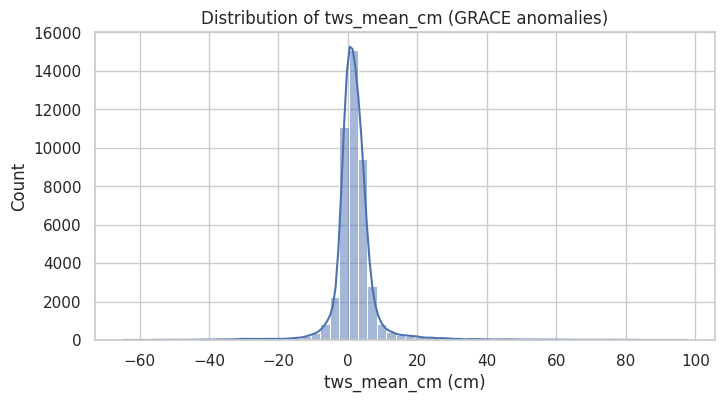


--- Boxplot: tws_mean_cm ---


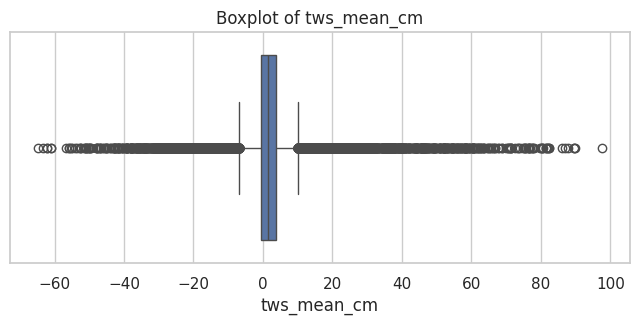


--- Global Time Series ---


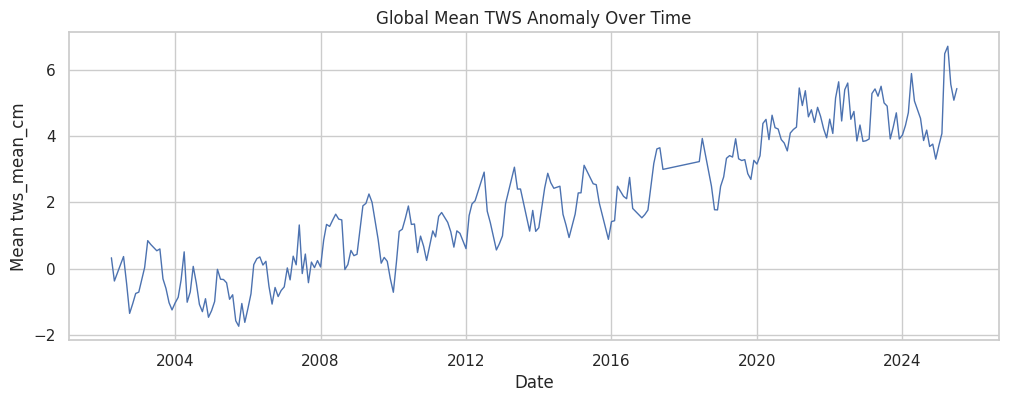


--- Top 20 Countries ---


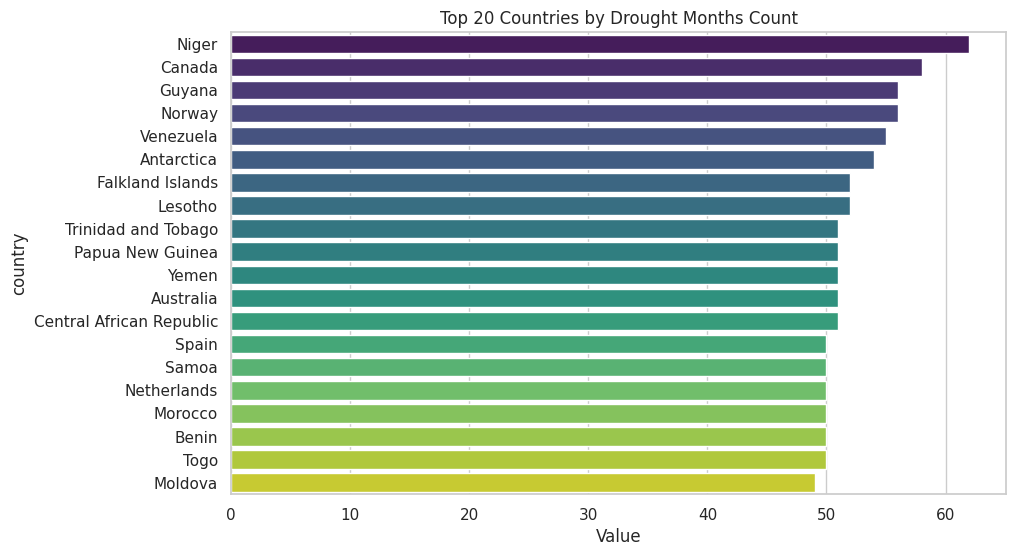


--- Aqueduct Labels ---


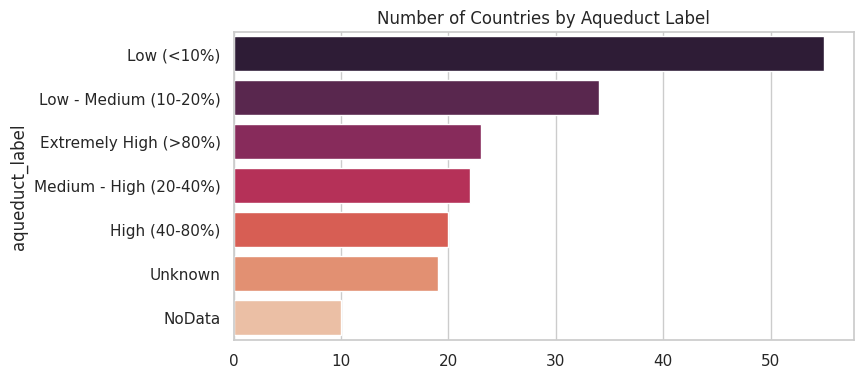


--- Correlation Matrix ---


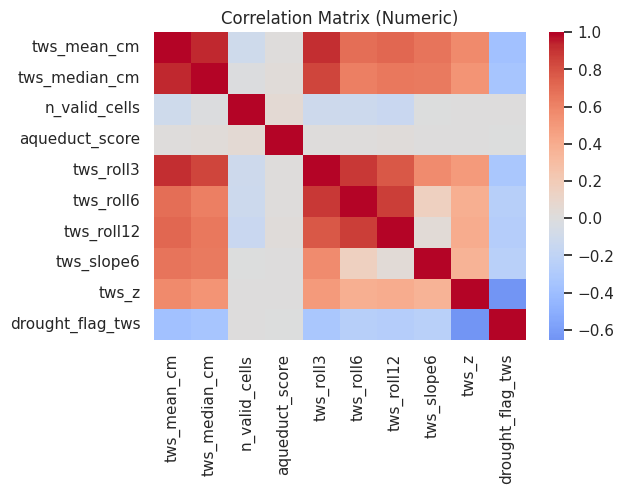


--- Scatter Plots ---


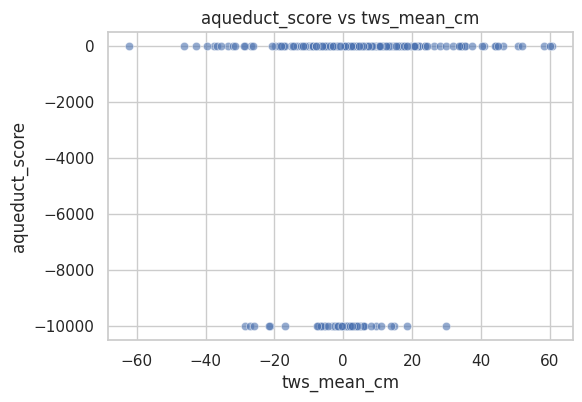

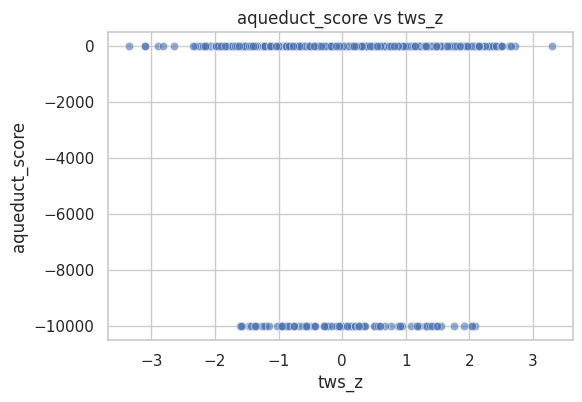

Saved Annual Stats CSV.
Saved Monthly Climatology CSV.

Saved final cleaned dataset: eda_outputs/drought_water_stress_master_monthly_clean.csv
Wrote summary to eda_outputs/eda_summary.txt
Generating PDF report...
Saved PDF Report: eda_outputs/eda_report.pdf

EDA Complete. All outputs located in: eda_outputs


In [54]:
# EDA_on_master_visualized.py
# Run this block to perform EDA, save figures, AND display them inline.

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats
try:
    from fpdf import FPDF
except ImportError:
    !pip install fpdf
    from fpdf import FPDF
import warnings
import pycountry

# Ensure plots display inline in the notebook
%matplotlib inline

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# ================= CONFIGURATION =================
# Update this path if necessary to match your file location
MASTER_CSV = "/content/drive/MyDrive/EDA-data/Test_4_file/drought_water_stress_master_monthly_norm_by_country.csv"

OUT_DIR = Path("eda_outputs")
OUT_DIR.mkdir(exist_ok=True)
FIG_DIR = OUT_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True)
CLEAN_CSV = OUT_DIR / "drought_water_stress_master_monthly_clean.csv"
REPORT_TXT = OUT_DIR / "eda_summary.txt"
REPORT_PDF = OUT_DIR / "eda_report.pdf"

DATE_COL = "date"
PREFERRED_COUNTRY_COL = "country"
FALLBACK_ISO_COL = "iso_a3"
REQUIRED_COLUMNS = [FALLBACK_ISO_COL, DATE_COL, "tws_mean_cm", "tws_median_cm", "n_valid_cells"]
MIN_VALID_CELLS = 5
# =================================================

# ================= HELPERS =================
def save_fig(fig, name, dpi=150):
    """Saves the figure to disk and displays it in the notebook."""
    path = FIG_DIR / name
    fig.savefig(path, bbox_inches='tight', dpi=dpi)
    plt.show()      # <--- THIS LINE ensures the plot appears in the output
    plt.close(fig)  # Close the figure to free memory after showing
    return path

def write_summary(lines):
    with open(REPORT_TXT, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))
    print("Wrote summary to", REPORT_TXT)

def iso3_to_name(iso3):
    try:
        if pd.isna(iso3) or str(iso3).strip()=="":
            return None
        c = pycountry.countries.get(alpha_3=str(iso3).upper())
        return c.name if c is not None else None
    except Exception:
        return None

# ================= MAIN EXECUTION =================

# --- 1. Load dataset ---
print(f"Loading: {MASTER_CSV}")
if not os.path.exists(MASTER_CSV):
    raise FileNotFoundError(f"File not found: {MASTER_CSV}")

df = pd.read_csv(MASTER_CSV, parse_dates=[DATE_COL])
print("Initial Shape:", df.shape)

# Drop fully blank columns
n_cols_before = df.shape[1]
df = df.dropna(axis=1, how='all')
print(f"Dropped fully-blank columns: {n_cols_before - df.shape[1]}")

# Ensure country column exists
if PREFERRED_COUNTRY_COL not in df.columns:
    if FALLBACK_ISO_COL in df.columns:
        print(f"Creating '{PREFERRED_COUNTRY_COL}' from {FALLBACK_ISO_COL}")
        df[PREFERRED_COUNTRY_COL] = df[FALLBACK_ISO_COL].apply(lambda x: iso3_to_name(x) if pd.notna(x) else None)
    else:
        # Fallback to any column that looks like a country name
        cand = next((c for c in ['name','country_name','Country','NAME'] if c in df.columns), None)
        if cand:
            df[PREFERRED_COUNTRY_COL] = df[cand].astype(str)
        else:
            print("Warning: No country/ISO column found. Proceeding without specific country mapping.")

# Normalize country names
if PREFERRED_COUNTRY_COL in df.columns:
    df[PREFERRED_COUNTRY_COL] = df[PREFERRED_COUNTRY_COL].astype(str).str.strip().replace({"nan": None})

ISO_COL = PREFERRED_COUNTRY_COL if PREFERRED_COUNTRY_COL in df.columns else FALLBACK_ISO_COL

# Ensure numeric columns
for col in ["tws_mean_cm", "tws_median_cm", "n_valid_cells"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter by valid cells
if "n_valid_cells" in df.columns:
    before = len(df)
    df = df[df["n_valid_cells"].fillna(0) >= MIN_VALID_CELLS].copy()
    print(f"Filtered rows by n_valid_cells >= {MIN_VALID_CELLS}: {before} -> {len(df)}")

# --- 2. Missing Values & Imputation ---
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean()*100).round(2)
missing_summary = pd.concat([missing, missing_pct], axis=1)
missing_summary.columns = ['n_missing','pct_missing']
missing_summary.to_csv(OUT_DIR / "missing_summary.csv")
print("\nSaved missing_summary.csv")

NUMERIC_COLS = df.select_dtypes(include=[np.number]).columns.tolist()
CAT_COLS = [c for c in df.columns if c not in NUMERIC_COLS and c != DATE_COL]

def fill_numeric_by_country(df_in, numeric_cols, country_col):
    df2 = df_in.copy()
    for c in numeric_cols:
        if c == "n_valid_cells":
            df2[c] = df2[c].fillna(0)
            continue

        # calculate medians
        if country_col in df2.columns:
            med_by_country = df2.groupby(country_col)[c].transform('median')
            df2[c] = df2[c].fillna(med_by_country)

        global_med = np.nanmedian(df2[c])
        df2[c] = df2[c].fillna(global_med)
    return df2

numeric_to_impute = [c for c in NUMERIC_COLS if c not in ("tws_mean_cm","tws_median_cm","n_valid_cells","year","month")]
df_filled = fill_numeric_by_country(df, numeric_to_impute, country_col=ISO_COL)

for c in CAT_COLS:
    if df_filled[c].dtype == object or pd.api.types.is_categorical_dtype(df_filled[c]):
        df_filled[c] = df_filled[c].fillna("Unknown")

df_filled = df_filled.drop_duplicates()

# --- 3. Descriptive Stats ---
desc_num = df_filled.select_dtypes(include=[np.number]).describe().T
desc_num.to_csv(OUT_DIR / "numeric_descriptive_stats.csv")
print("Saved numeric stats.")

# ================= VISUALIZATIONS =================

# 4.1 Histogram of TWS Mean
if "tws_mean_cm" in df_filled.columns:
    print("\n--- Histogram: tws_mean_cm ---")
    fig = plt.figure(figsize=(8, 4))
    sns.histplot(df_filled['tws_mean_cm'].dropna(), bins=60, kde=True)
    plt.title("Distribution of tws_mean_cm (GRACE anomalies)")
    plt.xlabel("tws_mean_cm (cm)")
    save_fig(fig, "hist_tws_mean_cm.png")

    # 4.2 Boxplot
    print("\n--- Boxplot: tws_mean_cm ---")
    fig = plt.figure(figsize=(8, 3))
    sns.boxplot(x=df_filled['tws_mean_cm'].dropna())
    plt.title("Boxplot of tws_mean_cm")
    save_fig(fig, "box_tws_mean_cm.png")

# 4.3 Global Time Series
if DATE_COL in df_filled.columns and "tws_mean_cm" in df_filled.columns:
    print("\n--- Global Time Series ---")
    fig = plt.figure(figsize=(12, 4))
    global_ts = df_filled.groupby(DATE_COL)['tws_mean_cm'].mean().reset_index()
    plt.plot(global_ts[DATE_COL], global_ts['tws_mean_cm'], linewidth=1)
    plt.title("Global Mean TWS Anomaly Over Time")
    plt.xlabel("Date")
    plt.ylabel("Mean tws_mean_cm")
    save_fig(fig, "global_mean_tws_ts.png")

# 4.4 Top 20 Countries
print("\n--- Top 20 Countries ---")
if "drought_flag_tws" in df_filled.columns:
    df_counts = df_filled.groupby(ISO_COL)['drought_flag_tws'].sum().sort_values(ascending=False).head(20)
    ylabel = "Drought Months Count"
elif "tws_mean_cm" in df_filled.columns:
    df_counts = df_filled.groupby(ISO_COL)['tws_mean_cm'].apply(lambda s: np.nanmean(np.abs(s))).sort_values(ascending=False).head(20)
    ylabel = "Mean Absolute TWS Magnitude"

fig = plt.figure(figsize=(10, 6))
sns.barplot(x=df_counts.values, y=df_counts.index, palette="viridis")
plt.title(f"Top 20 Countries by {ylabel}")
plt.xlabel("Value")
save_fig(fig, "top20_by_metric.png")

# 4.5 Aqueduct Labels
if "aqueduct_label" in df_filled.columns:
    print("\n--- Aqueduct Labels ---")
    labels = df_filled.groupby('aqueduct_label')[ISO_COL].nunique().sort_values(ascending=False)
    fig = plt.figure(figsize=(8, 4))
    sns.barplot(x=labels.values, y=labels.index, palette="rocket")
    plt.title("Number of Countries by Aqueduct Label")
    save_fig(fig, "aqueduct_label_by_country.png")

# 4.6 Correlation Matrix
print("\n--- Correlation Matrix ---")
num_for_corr = df_filled.select_dtypes(include=[np.number]).columns.tolist()
for drop_col in ['year', 'month']:
    if drop_col in num_for_corr:
        num_for_corr.remove(drop_col)

if len(num_for_corr) >= 2:
    corr = df_filled[num_for_corr].corr(method='pearson')
    fig = plt.figure(figsize=(6, 4))
    sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
    plt.title("Correlation Matrix (Numeric)")
    save_fig(fig, "corr_matrix_numeric.png")
    corr.to_csv(OUT_DIR / "correlation_matrix.csv")

# 4.7 Scatter Plots
print("\n--- Scatter Plots ---")
pairs = [('tws_mean_cm', 'aqueduct_score'), ('tws_z', 'aqueduct_score')]
for x, y in pairs:
    if x in df_filled.columns and y in df_filled.columns:
        fig = plt.figure(figsize=(6, 4))
        sns.scatterplot(data=df_filled.sample(min(2000, len(df_filled))), x=x, y=y, alpha=0.6)
        plt.title(f"{y} vs {x}")
        save_fig(fig, f"scatter_{x}_vs_{y}.png")

# ================= OUTLIERS & FEATURES =================

# 1. Outlier Detection (IQR Method)
if "tws_mean_cm" in df_filled.columns:
    def iqr_outlier_flags(series, k=1.5):
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        low = q1 - k * iqr
        high = q3 + k * iqr
        return (series < low) | (series > high), low, high

    flag, low, high = iqr_outlier_flags(df_filled['tws_mean_cm'].dropna())
    df_out = df_filled.copy()
    iqr_mask = (df_out['tws_mean_cm'] < low) | (df_out['tws_mean_cm'] > high)
    df_out['tws_outlier_iqr'] = iqr_mask

    # Save outlier sample
    if iqr_mask.any():
        df_out[iqr_mask].to_csv(OUT_DIR / "tws_iqr_outliers_sample.csv", index=False)

# 2. Feature Export (Annual/Monthly)
if 'year' not in df_out.columns and DATE_COL in df_out.columns:
    df_out['year'] = df_out[DATE_COL].dt.year
if 'month' not in df_out.columns and DATE_COL in df_out.columns:
    df_out['month'] = df_out[DATE_COL].dt.month

annual = df_out.groupby([ISO_COL, 'year']).agg({
    'tws_mean_cm': ['mean', 'median', 'min', 'max'],
    'n_valid_cells': 'sum',
})
annual.columns = ['_'.join(col).strip() for col in annual.columns.values]
annual = annual.reset_index()
annual.to_csv(OUT_DIR / "annual_country_stats.csv", index=False)
print("Saved Annual Stats CSV.")

monthly_clim = df_out.groupby([ISO_COL, 'month'])['tws_mean_cm'].mean().reset_index()
monthly_clim.to_csv(OUT_DIR / "monthly_climatology_country.csv", index=False)
print("Saved Monthly Climatology CSV.")

# 3. Final Cleaned CSV
df_out.to_csv(CLEAN_CSV, index=False)
print(f"\nSaved final cleaned dataset: {CLEAN_CSV}")

# 4. Summary Text
summary_lines = [
    "EDA Summary",
    "===========",
    f"Input master file: {MASTER_CSV}",
    f"Rows (after initial load & filter): {len(df)}",
    f"Rows (after filling & duplicate drop): {len(df_out)}",
    "",
    "Top missing columns (n_missing, pct):",
] + [f"{r}: {missing_summary.loc[r,'n_missing']} ({missing_summary.loc[r,'pct_missing']}%)" for r in missing_summary.index[:20]]

write_summary(summary_lines)

# ================= REPORTING =================
print("Generating PDF report...")
figure_files = [
    "global_mean_tws_ts.png",
    "hist_tws_mean_cm.png",
    "box_tws_mean_cm.png",
    "top20_by_metric.png",
    "corr_matrix_numeric.png"
]
figure_files = [FIG_DIR / f for f in figure_files if (FIG_DIR / f).exists()]

pdf = FPDF(orientation='P', unit='mm', format='A4')
pdf.set_auto_page_break(auto=True, margin=10)
pdf.add_page()
pdf.set_font("Arial", size=16)
pdf.cell(0, 10, "EDA Report: GRACE & Water Stress", ln=True, align='C')
pdf.set_font("Arial", size=12)
pdf.ln(10)
pdf.cell(0, 10, f"Total Rows Processed: {len(df_out)}", ln=True)

for figpath in figure_files:
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(0, 10, f"Figure: {figpath.name}", ln=True)
    # 180mm width to fit A4
    pdf.image(str(figpath), x=15, y=30, w=180)

pdf.output(str(REPORT_PDF))
print(f"Saved PDF Report: {REPORT_PDF}")
print(f"\nEDA Complete. All outputs located in: {OUT_DIR}")

### **Phase 4: Train & Evaluate Drought Risk Model**

**Accuracy Of Model using Confuion Matrix**

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

# 1. Load data
df = pd.read_csv('/content/drive/MyDrive/EDA-data/Test_4_file/outputs/drought_water_stress_master_monthly_clean.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['country', 'date'])

# 2. Target Engineering
df['target_next_drought'] = df.groupby('country')['drought_flag_tws'].shift(-1)
df_ml = df.dropna(subset=['target_next_drought']).copy()

# 3. Features
features = ['tws_mean_cm', 'tws_roll3', 'tws_roll6', 'tws_slope6', 'aqueduct_score', 'month', 'tws_z']
X = df_ml[features]
y = df_ml['target_next_drought']

# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 6. Metrics
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

In [45]:
print(f"Accuracy: {acc:.2%}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 89.05%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93      7438
         1.0       0.73      0.59      0.65      1566

    accuracy                           0.89      9004
   macro avg       0.82      0.77      0.79      9004
weighted avg       0.88      0.89      0.89      9004



confusion_matrix.png is saved


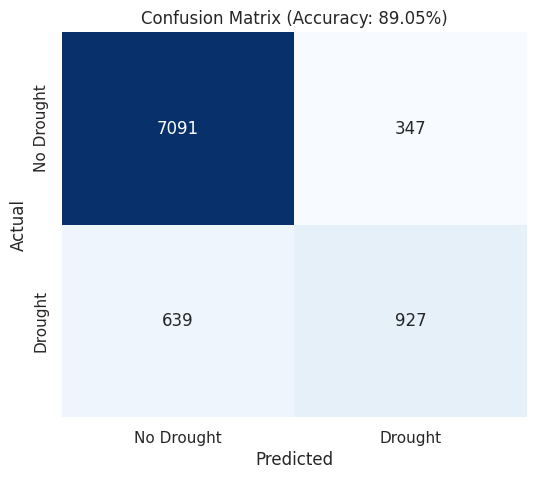

In [46]:
# 7. Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Drought', 'Drought'],
            yticklabels=['No Drought', 'Drought'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Accuracy: {acc:.2%})')

# Save
plt.savefig('confusion_matrix.png')
print("confusion_matrix.png is saved")


# SHOW it on the screen
plt.show()



In [47]:
# 8. Save the Model
joblib.dump(model, 'drought_risk_model.pkl')
print("Model saved as 'drought_risk_model.pkl'")

Model saved as 'drought_risk_model.pkl'


**Accuracy Of Model using Regression (R²)**

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# 1. Load Data
df = pd.read_csv('/content/drive/MyDrive/EDA-data/Test_4_file/outputs/drought_water_stress_master_monthly_clean.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['country', 'date'])

# 2. Target Engineering for REGRESSION (predicting the actual number, not a label)
# We shift 'tws_mean_cm' to predict next month's water level
df['target_next_tws'] = df.groupby('country')['tws_mean_cm'].shift(-1)
df_reg = df.dropna(subset=['target_next_tws']).copy()

# Features (same as before)
features = ['tws_mean_cm', 'tws_roll3', 'tws_roll6', 'tws_slope6', 'aqueduct_score', 'month', 'tws_z']
X = df_reg[features]
y = df_reg['target_next_tws']

# 3. Train Regressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regressor = RandomForestRegressor(n_estimators=50, random_state=42)
regressor.fit(X_train, y_train)

# 4. Calculate R^2
y_pred = regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"Regression Model R^2 Score: {r2:.2%}")

Regression Model R^2 Score: 88.86%


In [49]:
!pip install geopandas

 Shapefile loaded. Columns found: ['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3', 'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT', 'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG', 'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN', 'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT', 'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13', 'POP_EST', 'POP_RANK', 'POP_YEAR', 'GDP_MD', 'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'FIPS_10', 'ISO_A2', 'ISO_A2_EH', 'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'ISO_N3_EH', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID', 'WOE_ID_EH', 'WOE_NOTE', 'ADM0_ISO', 'ADM0_DIFF', 'ADM0_TLC', 'ADM0_A3_US', 'ADM0_A3_FR', 'ADM0_A3_RU', 'ADM0_A3_ES', 'ADM0_A3_CN', 'ADM0_A3_TW', 'ADM0_A3_IN', 'ADM0_A3_NP', 'ADM0_A3_PK', 'ADM0_A3_DE', 'ADM0_A3_GB', 'ADM0_A3_BR', 'ADM0_A3_IL', 'ADM0_A3_PS', 'ADM0_A3_SA', 'ADM0_A3_EG', 'ADM0_A3_MA', 'ADM0_A3_PT', 'ADM0_A3_AR', 'ADM0_A3_JP', 'ADM0_A3_KO

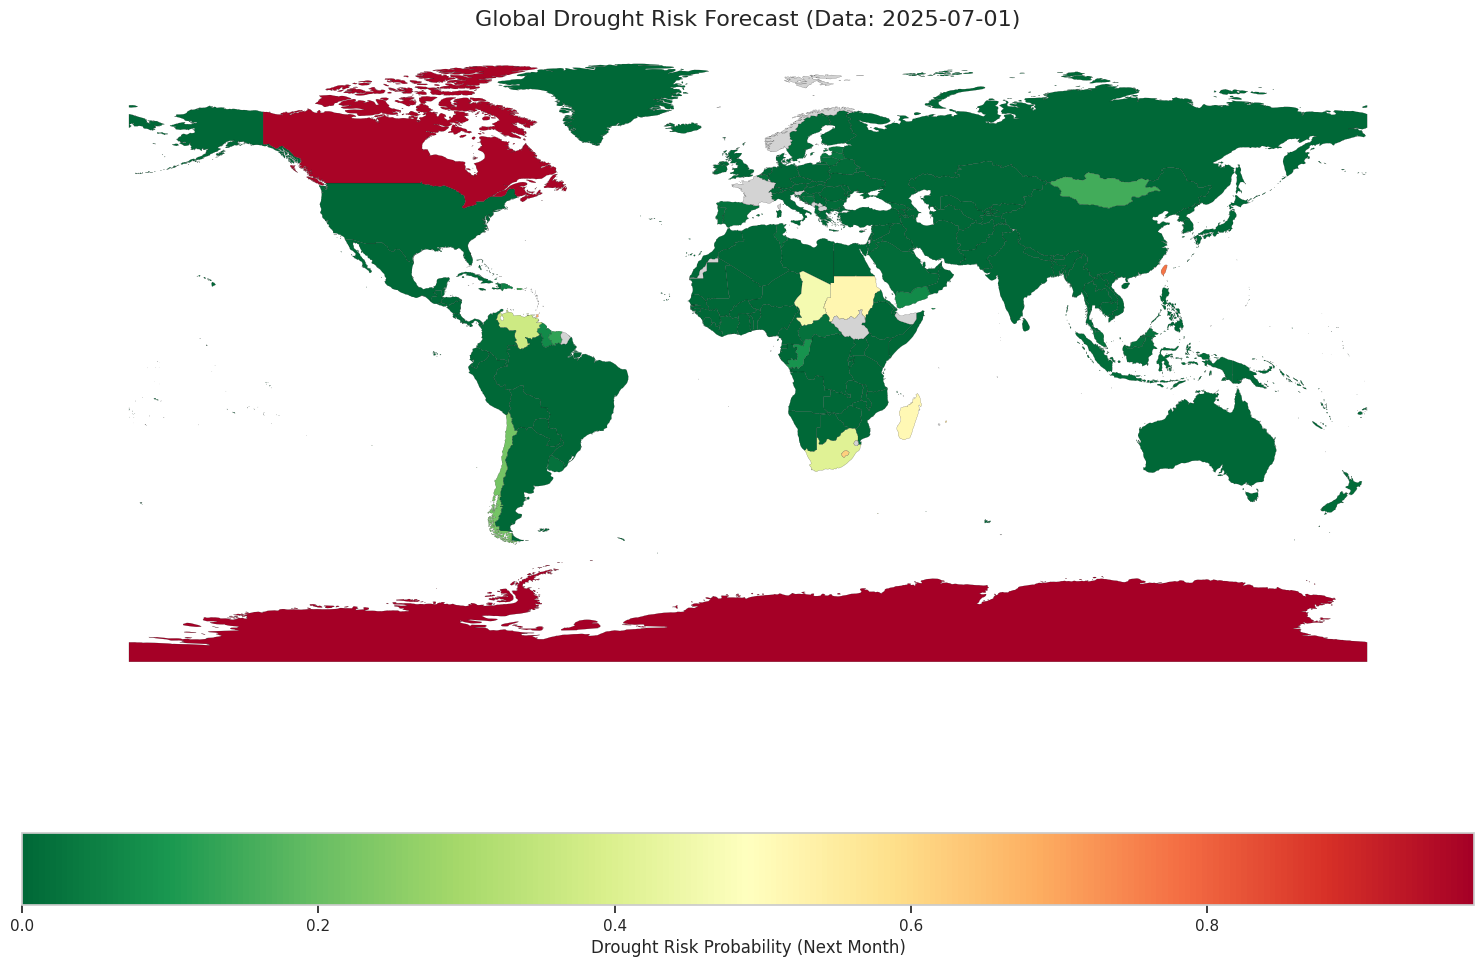

In [50]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# 1. Load Your Data & Model ---
df = pd.read_csv('/content/drive/MyDrive/EDA-data/Test_4_file/outputs/drought_water_stress_master_monthly_clean.csv')
df['date'] = pd.to_datetime(df['date'])

# Load the trained model
model = joblib.load('/content/drive/MyDrive/EDA-data/Test_4_file/outputs/Trained Model/drought_risk_model.pkl')

# 2. Load Custom Shapefile ---
shapefile_path = '/content/drive/MyDrive/EDA-data/shapefiles/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp'

try:
    world = gpd.read_file(shapefile_path)
    print(f" Shapefile loaded. Columns found: {world.columns.tolist()}")
except Exception as e:
    print(f" Error loading shapefile: {e}")
    print("Did you upload all parts? (.shp, .shx, .dbf are required)")

# 3. Prepare Predictions ---
# Get latest available data for each country
latest_date = df['date'].max()
latest_data = df[df['date'] == latest_date].copy()

# Define features (Must match model training)
features = ['tws_mean_cm', 'tws_roll3', 'tws_roll6', 'tws_slope6', 'aqueduct_score', 'month', 'tws_z']

# Predict
latest_data['drought_risk_prob'] = model.predict_proba(latest_data[features])[:, 1]

# --- 4. Merge Data with Shapefile ---
shapefile_key = 'ISO_A3'
csv_key = 'iso_a3'        # This is the column in your CSV

# Merge
world_map = world.merge(latest_data, left_on=shapefile_key, right_on=csv_key, how='left')

# --- 5. Plot the Map ---
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world_map.plot(column='drought_risk_prob',
               ax=ax,
               legend=True,
               cmap='RdYlGn_r', # Red = High Risk, Green = Low Risk
               edgecolor='black',
               linewidth=0.1,
               missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
               legend_kwds={'label': "Drought Risk Probability (Next Month)", 'orientation': "horizontal"})

ax.set_title(f"Global Drought Risk Forecast (Data: {latest_date.date()})", fontsize=16)
ax.set_axis_off()
plt.tight_layout()

# Save and Show
plt.savefig('custom_drought_map.png', dpi=300)
plt.show()

In [51]:
print("\nTop 5 countries by drought risk probability:")
top_5_countries = latest_data.sort_values(by='drought_risk_prob', ascending=False).head(5)
display(top_5_countries[['country', 'drought_risk_prob']])


Top 5 countries by drought risk probability:


,country,drought_risk_prob
1234,Antarctica,0.98
7162,Canada,0.97
39766,Taiwan,0.77
41248,Trinidad and Tobago,0.69
23711,Lesotho,0.62


from matplotlib import pyplot as plt
_df_0['drought_risk_prob'].plot(kind='hist', bins=20, title='drought_risk_prob')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('country').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['drought_risk_prob'].plot(kind='line', figsize=(8, 4), title='drought_risk_prob')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['country'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='drought_risk_prob', y='country', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)